# WhatPulse Keypress Stats Analyzer

By Kenneth Burchfiel

Released under the MIT license

*(I am not affiliated with WhatPulse (https://whatpulse.org) but highly recommend trying out the program, which I've used since September 2008. You can find my online WhatPulse page here: https://whatpulse.org/KBurchfiel)*

This script allows you to perform various analyses of your WhatPulse typing stats. It does so by accessing the local WhatPulse database on your computer (along with other copies of databases you might want to include); reading this data into Pandas DataFrames, and then summarizing and graphing that data. The output of the script includes:

1. Rolling average calculations at the 7-, 28-, and 365-day level
2. Percentile and rank calculations
3. Weekly and hourly keypress stats
4. Static (.png) and interactive (.html) keypress charts

By converting this notebook into a Python file and then instructing your computer to run it on an hourly basis, you can also keep track of how much you're typing during your day. Which is sort of nerdy, to be honest. But so is this whole program ;) 

I'll first import a number of packages that the program will use:

In [1]:
import time
start_time = time.time() # Allows the program's runtime to be measured
import pandas as pd
import sqlalchemy
import numpy as np
from datetime import date
import statsmodels.api as sm
from scipy.stats import percentileofscore
import plotly.express as px
import kaleido
from IPython.display import Image
import datetime

I'll next define the names of folders that will store various outputs, along with default settings to use when converting interactive charts to static .png files:

In [2]:
static_graphs_folder = 'graphs/static/'
interactive_graphs_folder = 'graphs/interactive/'
data_folder = 'data'

default_image_height = 540
default_aspect_ratio = 16 / 9 # Standard HD/UHD aspect ratio
default_image_width = default_image_height * default_aspect_ratio
default_image_scale = 5 # Creating a smaller graph (e.g. one 540 pixels 
# in height) and then scaling it helps keep the text a bit larger.

## Importing Whatpulse data

In order to analyze my WhatPulse data, I'll first need to import it from my local Whatpulse SQLite database. I'll also import a copy of the Whatpulse SQLite database stored on my old laptop (so that my analysis doesn't have to be limited to my current computer's keypress data.)

You'll of course need to update the following cell with the path(s) to your own WhatPulse database(s).

Note: if you want to run this program on your own, but don't have access to a WhatPulse database, you can still run this program (assuming you've downloaded or cloned it from GitHub). Skip ahead to the line where I read in 

In [3]:
database_paths_list = ['C:/Users/kburc/AppData/Local/whatpulse/whatpulse.db', 
'C:/Users/kburc/D1V1/Documents/whatpulse_database_backups/a13r2_whatpulse.db',
'G:/My Drive/whatpulse_database_backups/linux_whatpulse.db'] 
# Note that the first path is to my computer's active database, 
# whereas additional paths point towards copies of databases from 
# other computers that I have used.

The following function analyzes each database's  table at either the daily or hourly level.

In [4]:
def generate_keypress_totals(database_path, level = 'daily'):
    '''The level argument can be 'daily', in which case the DataFrame
    returned by the function will show daily keypress totals, or 'hourly',
    which will preserve the hourly keypress totals in the original database.'''
    file_name = database_path.split('/')[-1] # Retrieves the final element
    # of the path (e.g. the file name)
    sqlalchemy_sqlite_engine = sqlalchemy.create_engine(
        'sqlite:///'+database_path) 
    # Based on https://docs.sqlalchemy.org/en/13/dialects/sqlite.html#connect-strings
    sqlalchemy_connection = sqlalchemy_sqlite_engine.connect()
    df_keypresses = pd.read_sql("select * from keypresses", 
    con = sqlalchemy_sqlite_engine) # Simply reads all of the data from this 
    # Capitalizing column names so that less renaming will be necessary
    # when creating graphs:
    df_keypresses.columns = [column.title() for column in df_keypresses.columns]

    # table into a Pandas DataFrame
    df_keypresses = df_keypresses.query("Day != '0000-00-00'").copy() # Removes
    # this blank date value from the database if it happens to be there
    if level == 'daily': # In this case, we'll want to combine hourly keypress
        # totals into a single row for each day
        df_keypresses = df_keypresses.pivot_table(
            index = 'Day', values = 'Count', aggfunc = 'sum')
        df_keypresses.sort_values('Day', inplace = True)
    elif level == 'hourly': # The original data is already displayed 
        # at the hourly level, so there's no need for a pivot_table() call.
        df_keypresses.sort_values(['Day', 'Hour'], inplace = True)
    else:
        raise ValueError("Unrecognized level argument passed to function.")
    df_keypresses.rename(columns={'Count':'Keypresses'},inplace=True)  
    return df_keypresses

I'll now run generate_keypress_totals in order to create a record of daily keypresses for both my current database and a copy of a past database. (I'll look at hourly keypress totals later on.)

In [5]:
sqlalchemy_sqlite_engine = sqlalchemy.create_engine(
        'sqlite:///'+'C:/Users/kburc/AppData/Local/whatpulse/whatpulse.db') 
sqlalchemy_connection = sqlalchemy_sqlite_engine.connect()
sqlalchemy_connection

In [6]:
keypress_databases_list = []

for path in database_paths_list: # This loop creates a DataFrame for
    # each WhatPulse database stored in database_paths_list.
    print("Now loading:",path)
    keypress_databases_list.append(generate_keypress_totals(
        path, level = 'daily'))

# I'll now combine these tables into a single DataFrame.
df_combined_daily_keypresses = pd.concat(
    [keypress_databases_list[i] for i in range(len(keypress_databases_list))])
df_combined_daily_keypresses.sort_index(inplace=True)

# At this point, my copy of df_combined_daily_keypresses has multiple
# entries for days in which I logged keys on multiple operating systems.
# Therefore, the following line groups these entries into a single row
# for each date.
df_combined_daily_keypresses = df_combined_daily_keypresses.reset_index(
).pivot_table(index = 'Day', values = 'Keypresses', aggfunc = 'sum')
df_combined_daily_keypresses.index = pd.to_datetime(
    df_combined_daily_keypresses.index)

df_combined_daily_keypresses.to_csv('data/df_combined_daily_keypresses.csv')
df_combined_daily_keypresses

Now loading: C:/Users/kburc/AppData/Local/whatpulse/whatpulse.db
Now loading: C:/Users/kburc/D1V1/Documents/whatpulse_database_backups/a13r2_whatpulse.db
Now loading: G:/My Drive/whatpulse_database_backups/linux_whatpulse.db


Keypresses
Day                   
2020-09-21       19081
2020-09-22       32771
2020-09-23       32065
2020-09-24       34698
2020-09-25       47038
...                ...
2024-03-12       65458
2024-03-13       57509
2024-03-14       67124
2024-03-15       36963
2024-03-16       29865

[1204 rows x 1 columns]

The following line rebuilds df_combined_daily_keypresses using a copy of the DataFrame that got exported to a .csv file earlier on. This cell allows allow you to run this script even if you don't have your own WhatPulse database.

In [7]:
df_combined_daily_keypresses = pd.read_csv(
    'data/df_combined_daily_keypresses.csv', index_col='Day')
# The following line makes the index compatible with
# date operations that the following code block will perform.
df_combined_daily_keypresses.index = pd.to_datetime(
df_combined_daily_keypresses.index)
df_combined_daily_keypresses

Keypresses
Day                   
2020-09-21       19081
2020-09-22       32771
2020-09-23       32065
2020-09-24       34698
2020-09-25       47038
...                ...
2024-03-12       65458
2024-03-13       57509
2024-03-14       67124
2024-03-15       36963
2024-03-16       29865

[1204 rows x 1 columns]

The following code block fills in the DataFrame with missing dates (e.g. dates in which I did not have any keypresses). I want to add in those missing dates so that I can calculate more accurate rolling keypress averages.

In [8]:
first_date = df_combined_daily_keypresses.index[0]
last_date = df_combined_daily_keypresses.index[-1]
full_date_range = pd.date_range(start=first_date, end = last_date) 
# https://pandas.pydata.org/docs/reference/api/pandas.date_range.html
df_combined_daily_keypresses = df_combined_daily_keypresses.reindex(
    full_date_range, fill_value=0) 
# See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html

df_combined_daily_keypresses.index.name = 'Date'
df_combined_daily_keypresses.reset_index(inplace=True) 

Now that I have a more complete daily keypress history, I can begin performing analyses on this data. First, I will use the rolling() function within Pandas to calculate 7-, 28-, and 365-day moving averages. Next, I will use the Series.rank() function twice to (1) calculate the percentile of each keypress and (2) determine each keypress's rank within the entire DataFrame.

In [9]:
df_combined_daily_keypresses['7_day_ma'] = df_combined_daily_keypresses[
    'Keypresses'].rolling(7).mean()
df_combined_daily_keypresses['28_day_ma'] = df_combined_daily_keypresses[
    'Keypresses'].rolling(28).mean() 
# I switched from a 30-day MA to a 28-day MA because my average keypresses vary 
# significantly by weekday, meaning that a 30-day average would be skewed by 
# the number of Saturdays and Sundays present in the data.
df_combined_daily_keypresses['365_day_ma'] = df_combined_daily_keypresses[
    'Keypresses'].rolling(365).mean()

df_combined_daily_keypresses['percentile'] = 100*df_combined_daily_keypresses[
    'Keypresses'].rank(pct=True)
# The pct=True argument generates percentile values for each keypress value.
df_combined_daily_keypresses['rank'] = df_combined_daily_keypresses[
    'Keypresses'].rank(ascending = False)
# Ascending = False instructs the function to assign the lowest number 
# (e.g. 1) to the highest value.
# If two dates are tied, the rank may end in a 0.5. That's why these ranks 
# appear as floats but not integers. 
df_combined_daily_keypresses

Date  Keypresses      7_day_ma     28_day_ma    365_day_ma  \
0    2020-09-21       19081           NaN           NaN           NaN   
1    2020-09-22       32771           NaN           NaN           NaN   
2    2020-09-23       32065           NaN           NaN           NaN   
3    2020-09-24       34698           NaN           NaN           NaN   
4    2020-09-25       47038           NaN           NaN           NaN   
...         ...         ...           ...           ...           ...   
1268 2024-03-12       65458  32027.857143  19582.678571  25437.578082   
1269 2024-03-13       57509  33075.571429  21636.392857  25499.835616   
1270 2024-03-14       67124  42183.857143  23924.678571  25595.394521   
1271 2024-03-15       36963  47218.142857  24798.500000  25619.561644   
1272 2024-03-16       29865  45242.714286  24725.000000  25655.810959   

      percentile   rank  
0      40.298507  761.0  
1      65.514533  440.0  
2      64.179104  457.0  
3      69.010212  395.5  
4      87.274156  163.0  
...          ...    ...  
1268   97.800471   29.0  
1269   94.658288   69.0  
1270   98.350353   22.0  
1271   73.448547  339.0  
1272   59.858602  512.0  

[1273 rows x 7 columns]

Next, I'll add in weekdays using the Series.map() function within Pandas.

In [10]:
weekday_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',
5:'Saturday',6:'Sunday'}
# weekday numbers in Python begin with 0 for Monday and end with 6 for Sunday. 
# See https://docs.python.org/3/library/datetime.html#datetime.date.weekday
weekday_dict

{0: 'Monday',
 1: 'Tuesday',
 2: 'Wednesday',
 3: 'Thursday',
 4: 'Friday',
 5: 'Saturday',
 6: 'Sunday'}

The following cell adds a 'Weekday' column to the DataFrame by (1) calculating the numerical weekday values for each date in the 'Date' column, then (2) using weekday_dict to map these numerical values to the weekday names. 

In [11]:
df_combined_daily_keypresses['Weekday'] = df_combined_daily_keypresses[
    'Date'].dt.weekday.map(weekday_dict)

Here are my daily keypress statistics for the last 10 days. Note the presence of the moving average, percentile, rank, and weekday columns.

In [12]:
df_combined_daily_keypresses.tail(10)

Date  Keypresses      7_day_ma     28_day_ma    365_day_ma  \
1263 2024-03-07        3366  14614.142857  15419.678571  25332.695890   
1264 2024-03-08        1723  14731.857143  15409.500000  25286.715068   
1265 2024-03-09       43693  20970.142857  16807.500000  25317.641096   
1266 2024-03-10         111  20977.142857  16149.178571  25273.569863   
1267 2024-03-11       59669  28532.000000  18040.607143  25380.912329   
1268 2024-03-12       65458  32027.857143  19582.678571  25437.578082   
1269 2024-03-13       57509  33075.571429  21636.392857  25499.835616   
1270 2024-03-14       67124  42183.857143  23924.678571  25595.394521   
1271 2024-03-15       36963  47218.142857  24798.500000  25619.561644   
1272 2024-03-16       29865  45242.714286  24725.000000  25655.810959   

      percentile    rank    Weekday  
1263   16.732129  1061.0   Thursday  
1264   13.040063  1108.0     Friday  
1265   83.582090   210.0   Saturday  
1266    7.305577  1181.0     Sunday  
1267   95.679497    56.0     Monday  
1268   97.800471    29.0    Tuesday  
1269   94.658288    69.0  Wednesday  
1270   98.350353    22.0   Thursday  
1271   73.448547   339.0     Friday  
1272   59.858602   512.0   Saturday

# Data Analysis

I'll start my data analysis by calculating some summary statistics. In the output below, 'count' shows the number of days since the earliest entry in my database, rather than the number of days for which I have keypress data (as the table also includes days without any keypresses).

In [13]:
df_combined_daily_keypresses['Keypresses'].describe()

count      1273.000000
mean      25355.311862
std       18766.514060
min           0.000000
25%        8712.000000
50%       24829.000000
75%       37989.000000
max      121833.000000
Name: Keypresses, dtype: float64

Next, I'll calculate my top 50 daily keypress totals. Note that the top-ranked date has a rank of 1 and a percentile of 100.

In [14]:
df_max_keypresses = df_combined_daily_keypresses.sort_values(
    'Keypresses', ascending = False).reset_index(drop=True)
df_max_keypresses.insert(0, 'Rank', df_max_keypresses.index+1)
keypress_difference_list = [
    df_max_keypresses.iloc[i]['Keypresses'] - df_max_keypresses.iloc[i+1][
        'Keypresses'] for i in range(len(df_max_keypresses) -1 )]
# The above list comprehension calculates the difference 
# between each row and the row below it. This isn't possible for the final row,
# so I'll instead append a np.Nan to it.)
keypress_difference_list.append(np.NaN)
df_max_keypresses['difference_from_lower_rank'] = keypress_difference_list
df_max_keypresses.head(50)

Rank       Date  Keypresses      7_day_ma     28_day_ma    365_day_ma  \
0      1 2024-01-08      121833  55373.857143  42174.785714  25960.498630   
1      2 2023-11-18      104525  48377.000000  36835.035714  23188.216438   
2      3 2024-01-03       94380  35844.142857  41919.392857  25558.646575   
3      4 2022-12-05       90447  34728.714286  26518.821429  20476.994521   
4      5 2023-12-07       81369  56303.857143  43351.821429  24036.515068   
5      6 2023-12-26       79499  45022.571429  47711.428571  25165.372603   
6      7 2024-01-02       78643  23509.571429  40957.500000  25406.241096   
7      8 2021-02-22       77753  47983.000000  41390.857143           NaN   
8      9 2020-11-23       76313  50377.571429  39924.107143           NaN   
9     10 2020-11-19       75444  47285.571429  37945.892857           NaN   
10    11 2021-11-09       73788  37843.285714  30462.071429  29584.802740   
11    12 2023-11-29       73736  33759.571429  38933.714286  23717.972603   
12    13 2022-05-03       72910  30511.428571  28489.285714  24401.624658   
13    14 2023-12-19       71406  50155.142857  42303.535714  24531.665753   
14    15 2021-02-08       70591  30177.428571  34437.357143           NaN   
15    16 2024-01-24       68403  42259.428571  35836.928571  26463.991781   
16    17 2021-04-06       68313  40455.857143  40719.178571           NaN   
17    18 2021-02-15       67930  46174.571429  40268.535714           NaN   
18    19 2020-11-30       67533  20747.428571  36843.714286           NaN   
19    20 2021-02-17       67505  45946.571429  40801.607143           NaN   
20    21 2023-12-06       67447  49626.857143  41540.107143  23935.002740   
21    22 2024-03-14       67124  42183.857143  23924.678571  25595.394521   
22    23 2021-10-12       66517  39971.285714  36729.892857  29886.202740   
23    24 2021-10-14       65935  46708.142857  37694.500000  30001.038356   
24    25 2021-09-23       65907  33891.142857  27215.107143  30006.980822   
25    26 2023-11-28       65836  23391.000000  37445.035714  23572.430137   
26    27 2023-12-02       65545  50889.857143  41582.607143  23857.506849   
27    28 2021-09-27       65464  35955.714286  29346.285714  29877.052055   
28    29 2024-03-12       65458  32027.857143  19582.678571  25437.578082   
29    30 2023-12-05       65076  50525.285714  41125.964286  23875.378082   
30    31 2021-01-25       64903  43493.714286  27181.714286           NaN   
31    32 2020-10-01       64873  41882.285714           NaN           NaN   
32    33 2023-05-31       64683  26243.000000  21224.750000  20534.572603   
33    34 2023-11-21       63528  58554.142857  40021.678571  23578.621918   
34    35 2022-08-22       63149  23130.428571  21345.785714  22784.887671   
35    36 2024-01-12       62973  45097.000000  40422.428571  26080.668493   
36    37 2021-10-26       62922  30820.000000  37036.107143  29899.287671   
37    38 2021-04-07       62668  41278.000000  40999.857143           NaN   
38    39 2022-04-26       62596  31803.714286  29291.607143  23983.284932   
39    40 2021-02-19       62473  47705.571429  41579.714286           NaN   
40    41 2022-05-26       62030  21439.571429  20150.964286  23948.786301   
41    42 2020-12-15       61969  44707.000000  35868.785714           NaN   
42    43 2020-12-03       61437  36799.571429  36592.642857           NaN   
43    44 2023-11-19       61303  51730.000000  39024.428571  23319.736986   
44    45 2022-04-25       61200  28113.428571  28472.321429  23845.347945   
45    46 2023-09-01       61187  35851.857143  28069.035714  21375.032877   
46    47 2023-12-15       61156  44444.000000  46239.678571  24283.523288   
47    48 2022-01-21       60953  38414.857143  17726.821429  27924.994521   
48    49 2023-12-13       60893  44206.428571  45181.571429  24171.989041   
49    50 2020-10-08       60890  42957.571429           NaN           NaN   

    percentile  rank    Weekday  difference_from_lower_rank  
0   100.000000

Next, I'll create a visualization of these 50 dates. I will use Plotly instead of Matplotlib so that I can create both interactive (.html) and static (.png) versions of each chart. The static versions are easier to share, but the interactive versions are easier to analyze, as you can hover over the chart to get more information and zoom in on areas of particular interest.

First, I'll create a function that will make it easier to save .html and .png versions of these charts:

In [15]:
def save_chart(fig, file_name, 
interactive_graphs_folder = interactive_graphs_folder, 
static_graphs_folder = static_graphs_folder):
    '''Saves a Plotly figure as a .HTML and .PNG file.
    fig: The Plotly figure to save.
    file_name: The filename to use. Don't include the extension.'''
    fig.write_html(
        interactive_graphs_folder+'/'+file_name+'.html')
    # Saving the interactive chart to a .png file:
    fig.write_image(
        static_graphs_folder+'/'+file_name+'.png',
        width = default_image_width, height = default_image_height,
        scale = default_image_scale)

In [16]:
# Generating the interactive chart:
fig_max_keypresses = px.bar(df_max_keypresses.head(50), 
x = 'Rank', y = 'Keypresses', title = 'Top 50 Daily Keypress Totals', 
text = 'Keypresses')

save_chart(fig_max_keypresses, 'top_50_keypresses')

Here's a look at the chart:

*Note: this and other .html-based charts will probably not display for you within GitHub. In order to view them, you will need to download the files from GitHub (e.g. by cloning them) and view them on your computer.*

In [17]:
fig_max_keypresses

Here's a copy of the static chart in case the .html chart above did not load for you: (I'll also display static versions of later charts as well.)

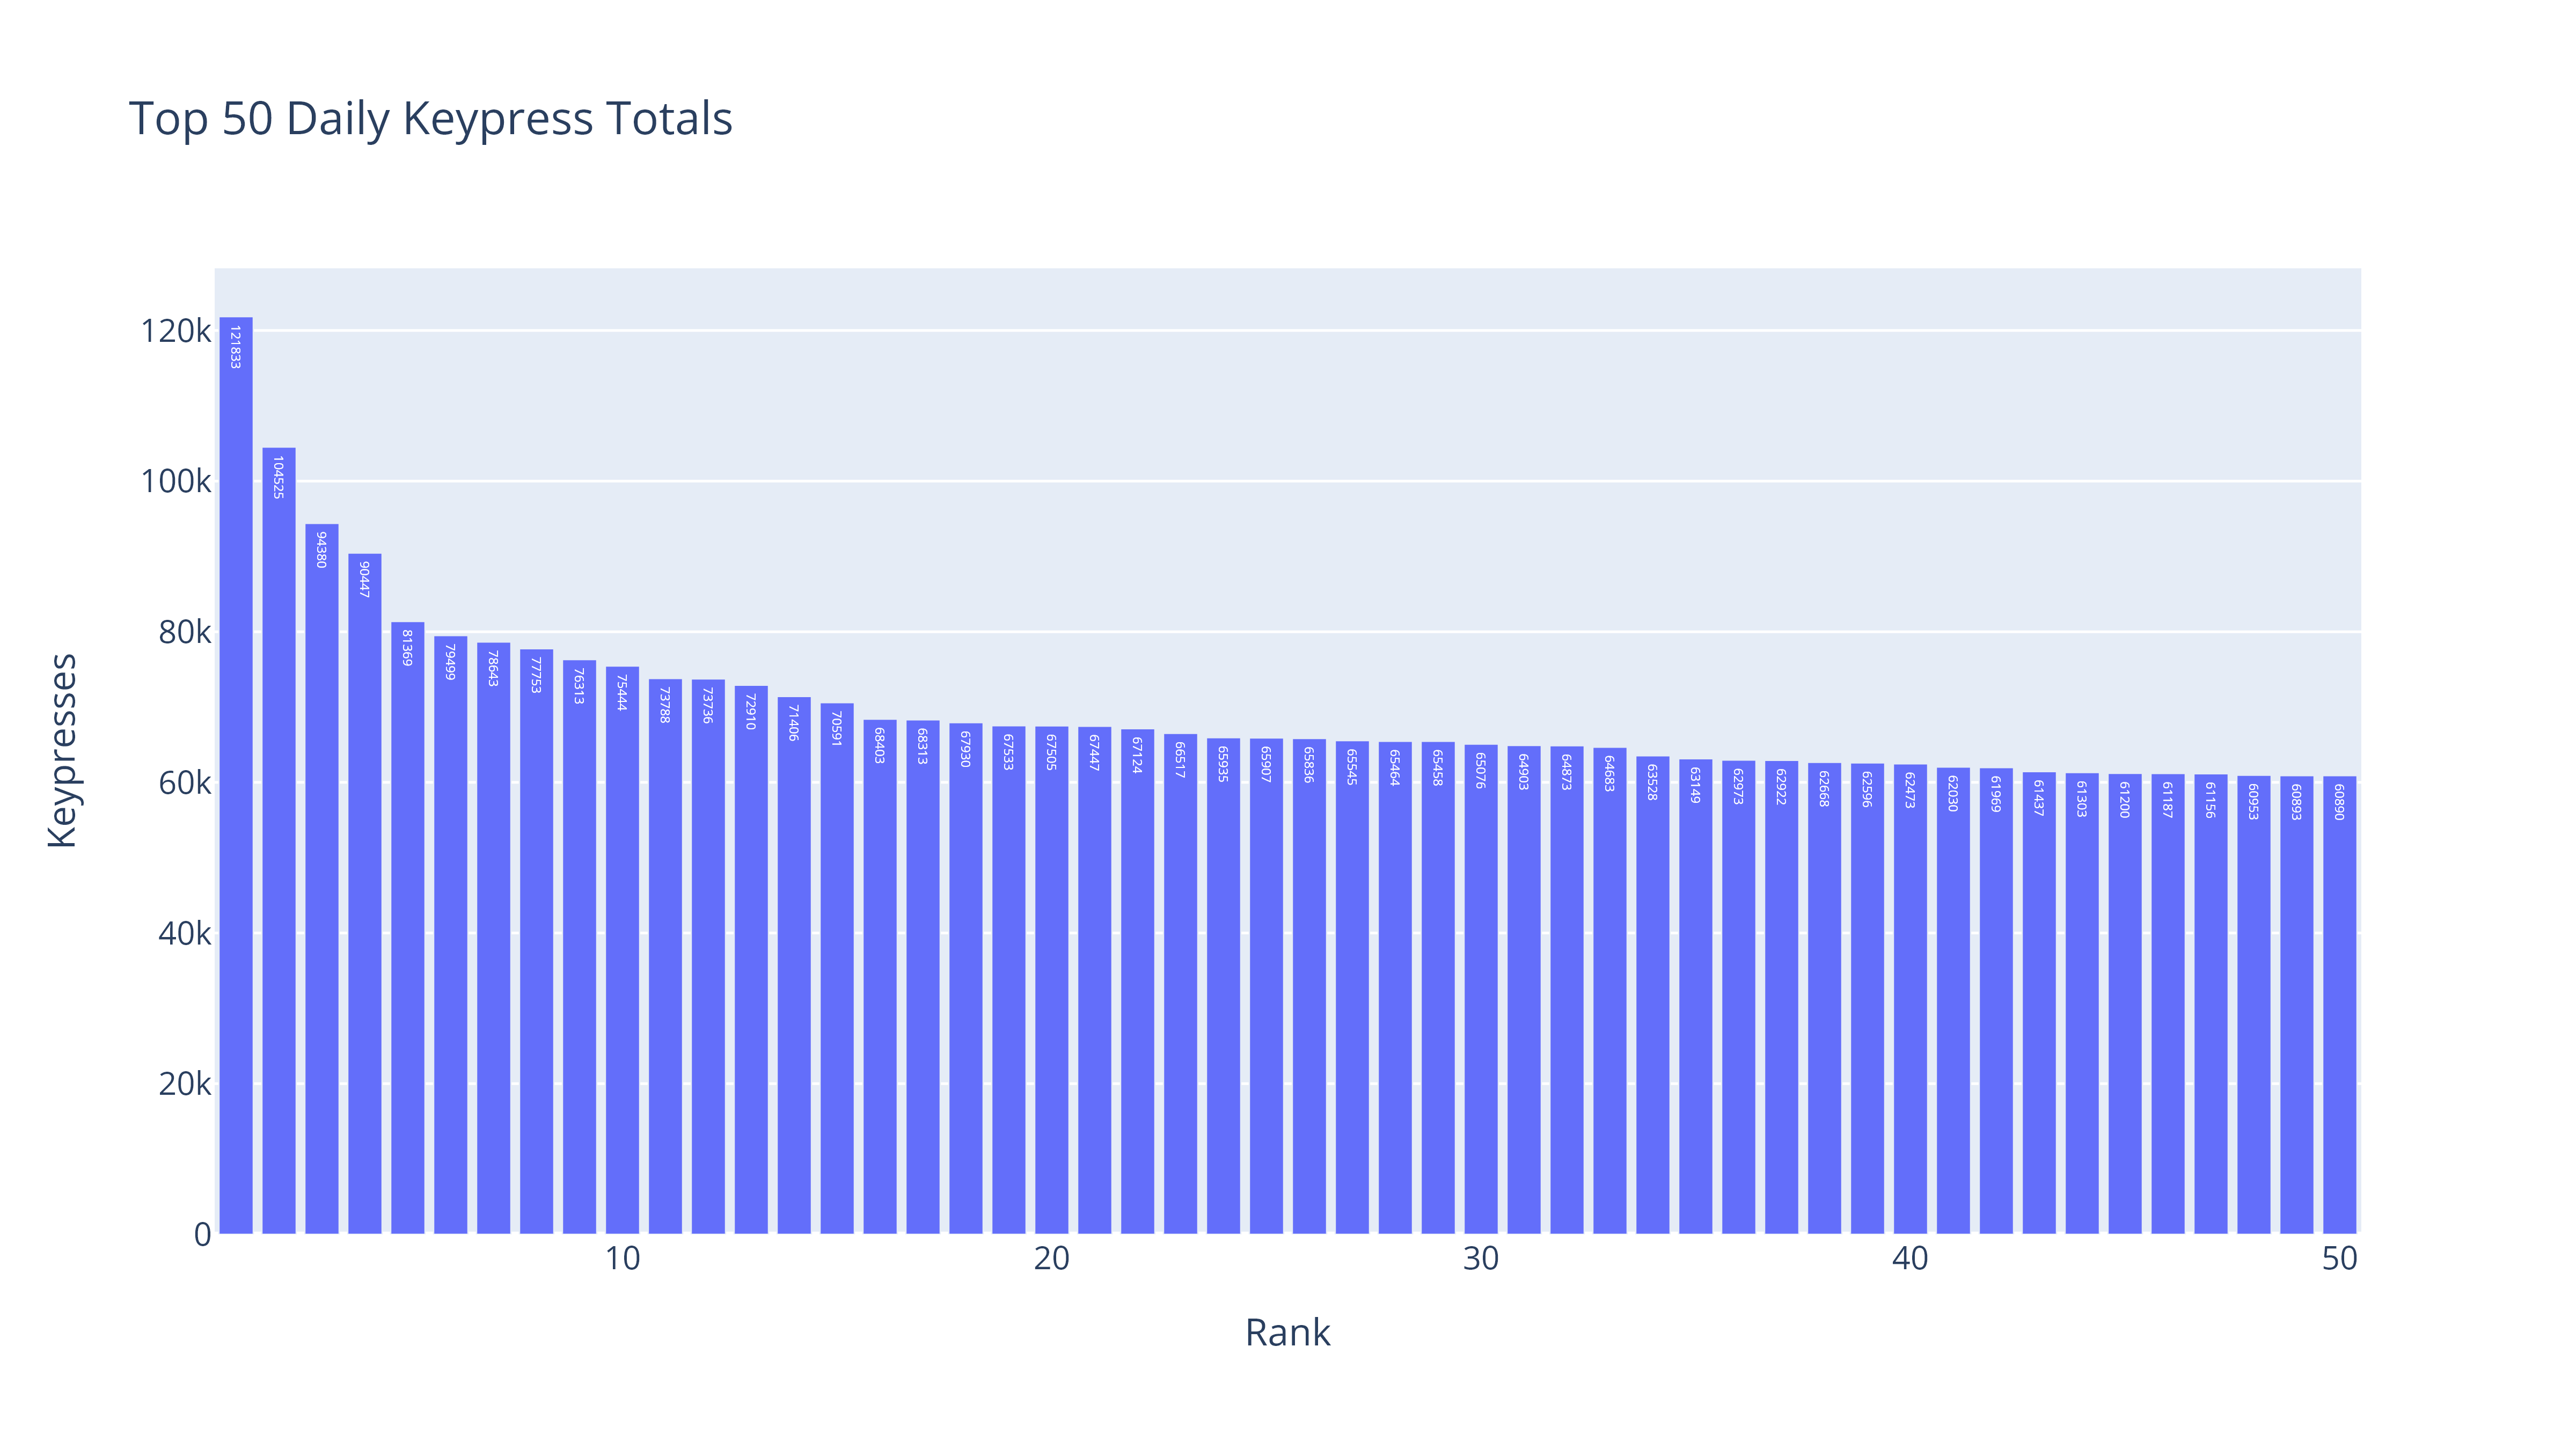

In [18]:
Image(static_graphs_folder+'top_50_keypresses.png')

## Keypress percentile data:

First, I'll calculate the keypress totals equal to the 90th through 100th percentiles (in 1-percentile increments).

In [19]:
df_combined_daily_keypresses['Keypresses'].describe(
    percentiles=np.linspace(0.9,1,11))[5:-1]
# The first four rows and final row provide additional descriptive statistics,
# so we can get rid of them
# by adding [4:-1] to the end of this line.
# There is probably a more elegant solution that retrieves only percentile
# data, but this option is fairly straightforward.

90%      50010.40
91%      51265.52
92%      53222.96
93%      54594.20
94%      56848.44
95%      58115.00
96%      60765.44
97%      62576.32
98%      65707.96
99%      71827.12
100%    121833.00
Name: Keypresses, dtype: float64

Scipy's percentileofscore() function can be used to calculate the percentile corresponding to a specific keypress total. For instance, here's the percentile for a day with only a single keypress: (The percentile may be higher than you'd expect due to the presence of many days with 0 keypresses)

In [20]:
percentileofscore(df_combined_daily_keypresses['Keypresses'], 1)

5.813040062843676

Next, I'll create a DataFrame showing the keypresses corresponding to every 5th percentile.

In [21]:
df_percentiles = df_combined_daily_keypresses['Keypresses'].describe(
percentiles=np.linspace(0,1,21))[4:-1].reset_index().sort_values(
    'Keypresses', ascending = False).reset_index(drop=True).rename(
        columns={'index':'percentile'})
# Calling reset_index() twice appears inefficient, but it makes it easier
# to sort by a particular value (in this case, keypresses).
keypress_difference_list = [df_percentiles.iloc[
    i, 1] - df_percentiles.iloc[i+1, 1] for i in range(len(df_percentiles) -1 )]
# This list comprehension calculates the difference between each row and 
# the row below it. This isn't possible for the final row,
# so we'll instead append a np.Nan to it.)
keypress_difference_list.append(np.NaN)
df_percentiles['difference_from_lower_percentile'] = keypress_difference_list
df_percentiles

percentile  Keypresses  difference_from_lower_percentile
0        100%    121833.0                           63718.0
1         95%     58115.0                            8104.6
2         90%     50010.4                            5066.0
3         85%     44944.4                            3762.6
4         80%     41181.8                            3192.8
5         75%     37989.0                            2817.4
6         70%     35171.6                            2901.2
7         65%     32270.4                            2344.0
8         60%     29926.4                            2958.2
9         55%     26968.2                            2139.2
10        50%     24829.0                            2930.2
11        45%     21898.8                            2929.0
12        40%     18969.8                            2792.8
13        35%     16177.0                            3502.2
14        30%     12674.8                            3962.8
15        25%      8712.0                            2770.2
16        20%      5941.8                            3448.8
17        15%      2493.0                            1716.6
18        10%       776.4                             776.4
19         5%         0.0                               0.0
20         0%         0.0                               NaN

The following chart shows the difference in keypresses between the different percentiles on this list.

In [22]:
px.bar(df_percentiles, x = 'percentile', 
       y = 'difference_from_lower_percentile')

And here's a histogram that shows the frequency of different keypress ranges:

In [23]:
fig_keypress_hist = px.histogram(df_combined_daily_keypresses, 
x = 'Keypresses', nbins = 40, text_auto = True, 
title = 'Histogram of Daily Keypress Totals')
# See https://plotly.com/python/histograms/
fig_keypress_hist.update_layout(bargap=0.1, yaxis_title = 'Days')
# https://plotly.com/python/histograms/
save_chart(fig_keypress_hist, 'daily_keypress_histogram')
fig_keypress_hist

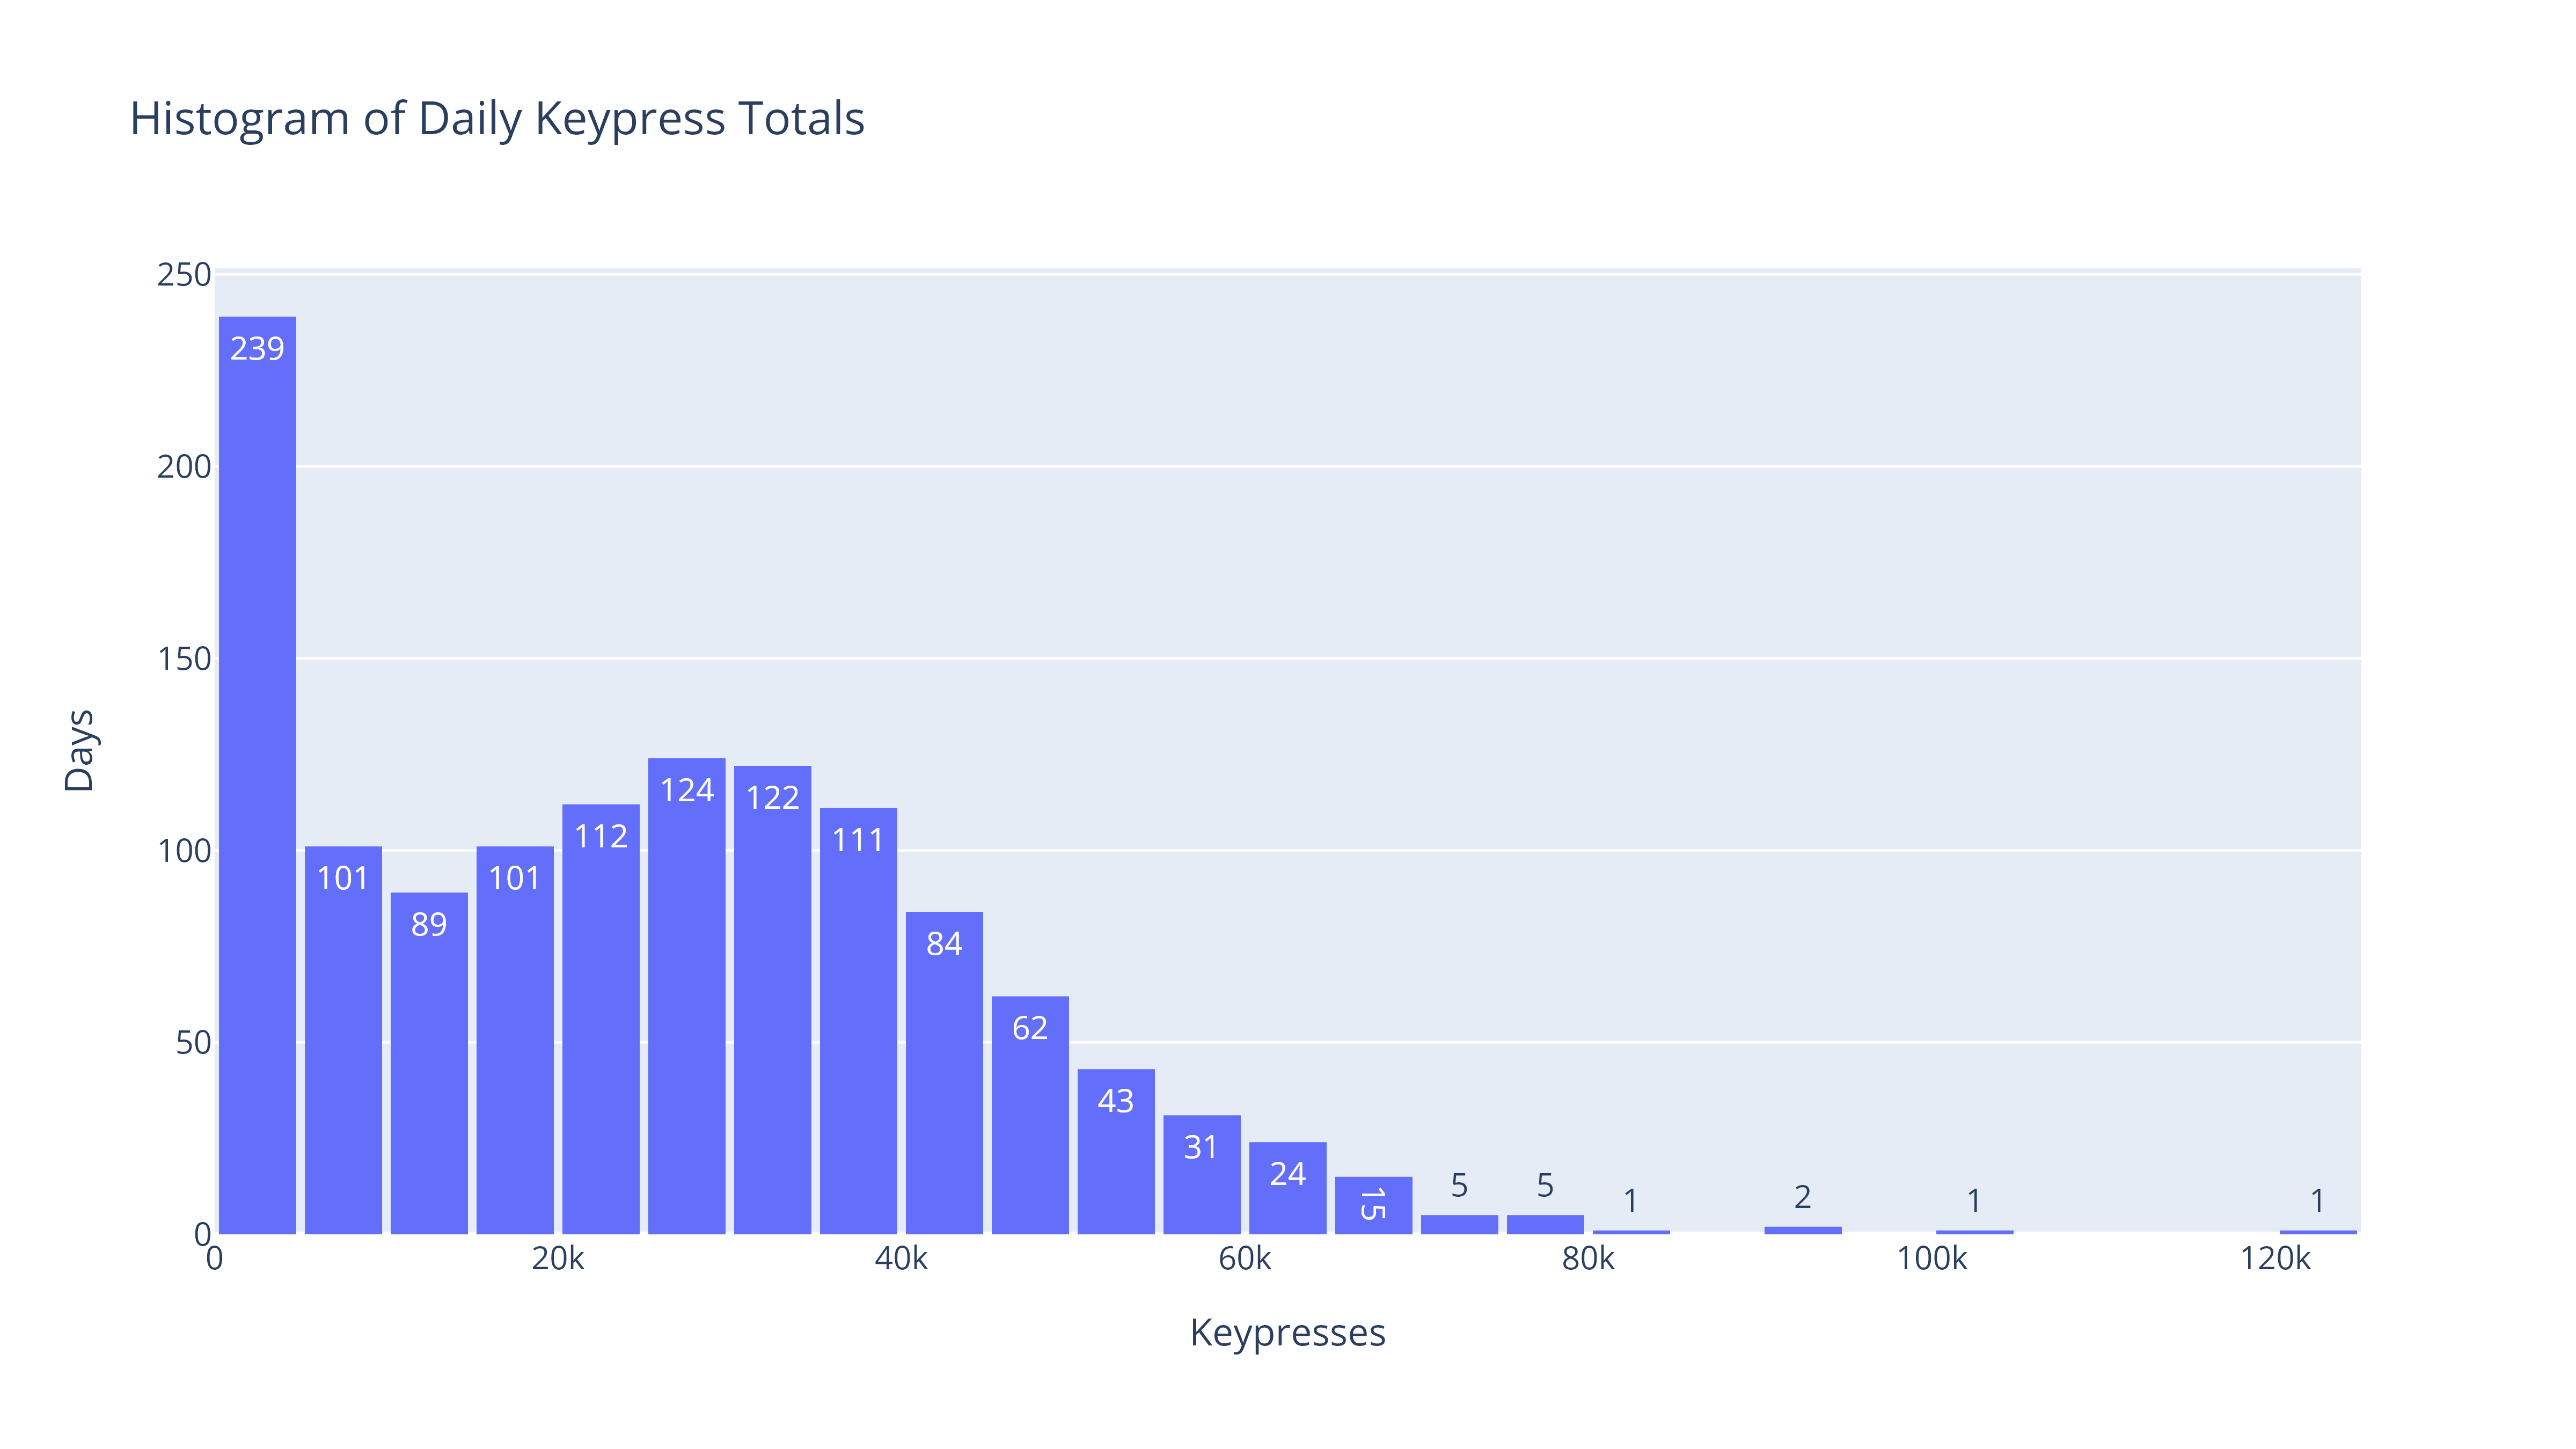

In [24]:
Image(static_graphs_folder+'daily_keypress_histogram.png')

I'll now create a pivot table that shows my average keypresses per weekday:

In [25]:
df_weekday_pivot = df_combined_daily_keypresses.pivot_table(
    index = 'Weekday', values = 'Keypresses', aggfunc = 'mean').sort_values(
    'Weekday', ascending = False).reset_index()
# Adding in a Weekday_Order column so that 
# weekdays can be sorted chronologically:
df_weekday_pivot['Weekday_Order'] = df_weekday_pivot['Weekday'].map(
{'Sunday':0,'Monday':1,"Tuesday":2,"Wednesday":3,
"Thursday":4,"Friday":5,"Saturday":6})
df_weekday_pivot

Weekday    Keypresses  Weekday_Order
0  Wednesday  31415.642857              3
1    Tuesday  32974.538462              2
2   Thursday  30795.065934              4
3     Sunday  11635.508287              0
4   Saturday  14914.456044              6
5     Monday  31004.730769              1
6     Friday  24671.857143              5

In [26]:
df_weekday_pivot.sort_values('Weekday_Order', inplace = True)
df_weekday_pivot

Weekday    Keypresses  Weekday_Order
3     Sunday  11635.508287              0
5     Monday  31004.730769              1
1    Tuesday  32974.538462              2
0  Wednesday  31415.642857              3
2   Thursday  30795.065934              4
6     Friday  24671.857143              5
4   Saturday  14914.456044              6

Graphing my average keypresses per weekday:

In [27]:
fig_keypresses_by_weekday = px.bar(df_weekday_pivot, x = 'Weekday', 
y = 'Keypresses', text_auto = '.0f', color = 'Keypresses', 
color_continuous_scale = 'PrGn',
title = 'Average Keypresses by Weekday')
# For text_auto, see: 
# https://plotly.com/python-api-reference/generated/plotly.express.bar

# For color scale options and usage, 
# visit https://plotly.com/python/builtin-colorscales/
fig_keypresses_by_weekday.update_traces(marker_line_color='rgb(0,0,0)', 
                                        marker_line_width=0.5, opacity=1)
fig_keypresses_by_weekday

save_chart(fig_keypresses_by_weekday, file_name = 'keypresses_by_weekday')

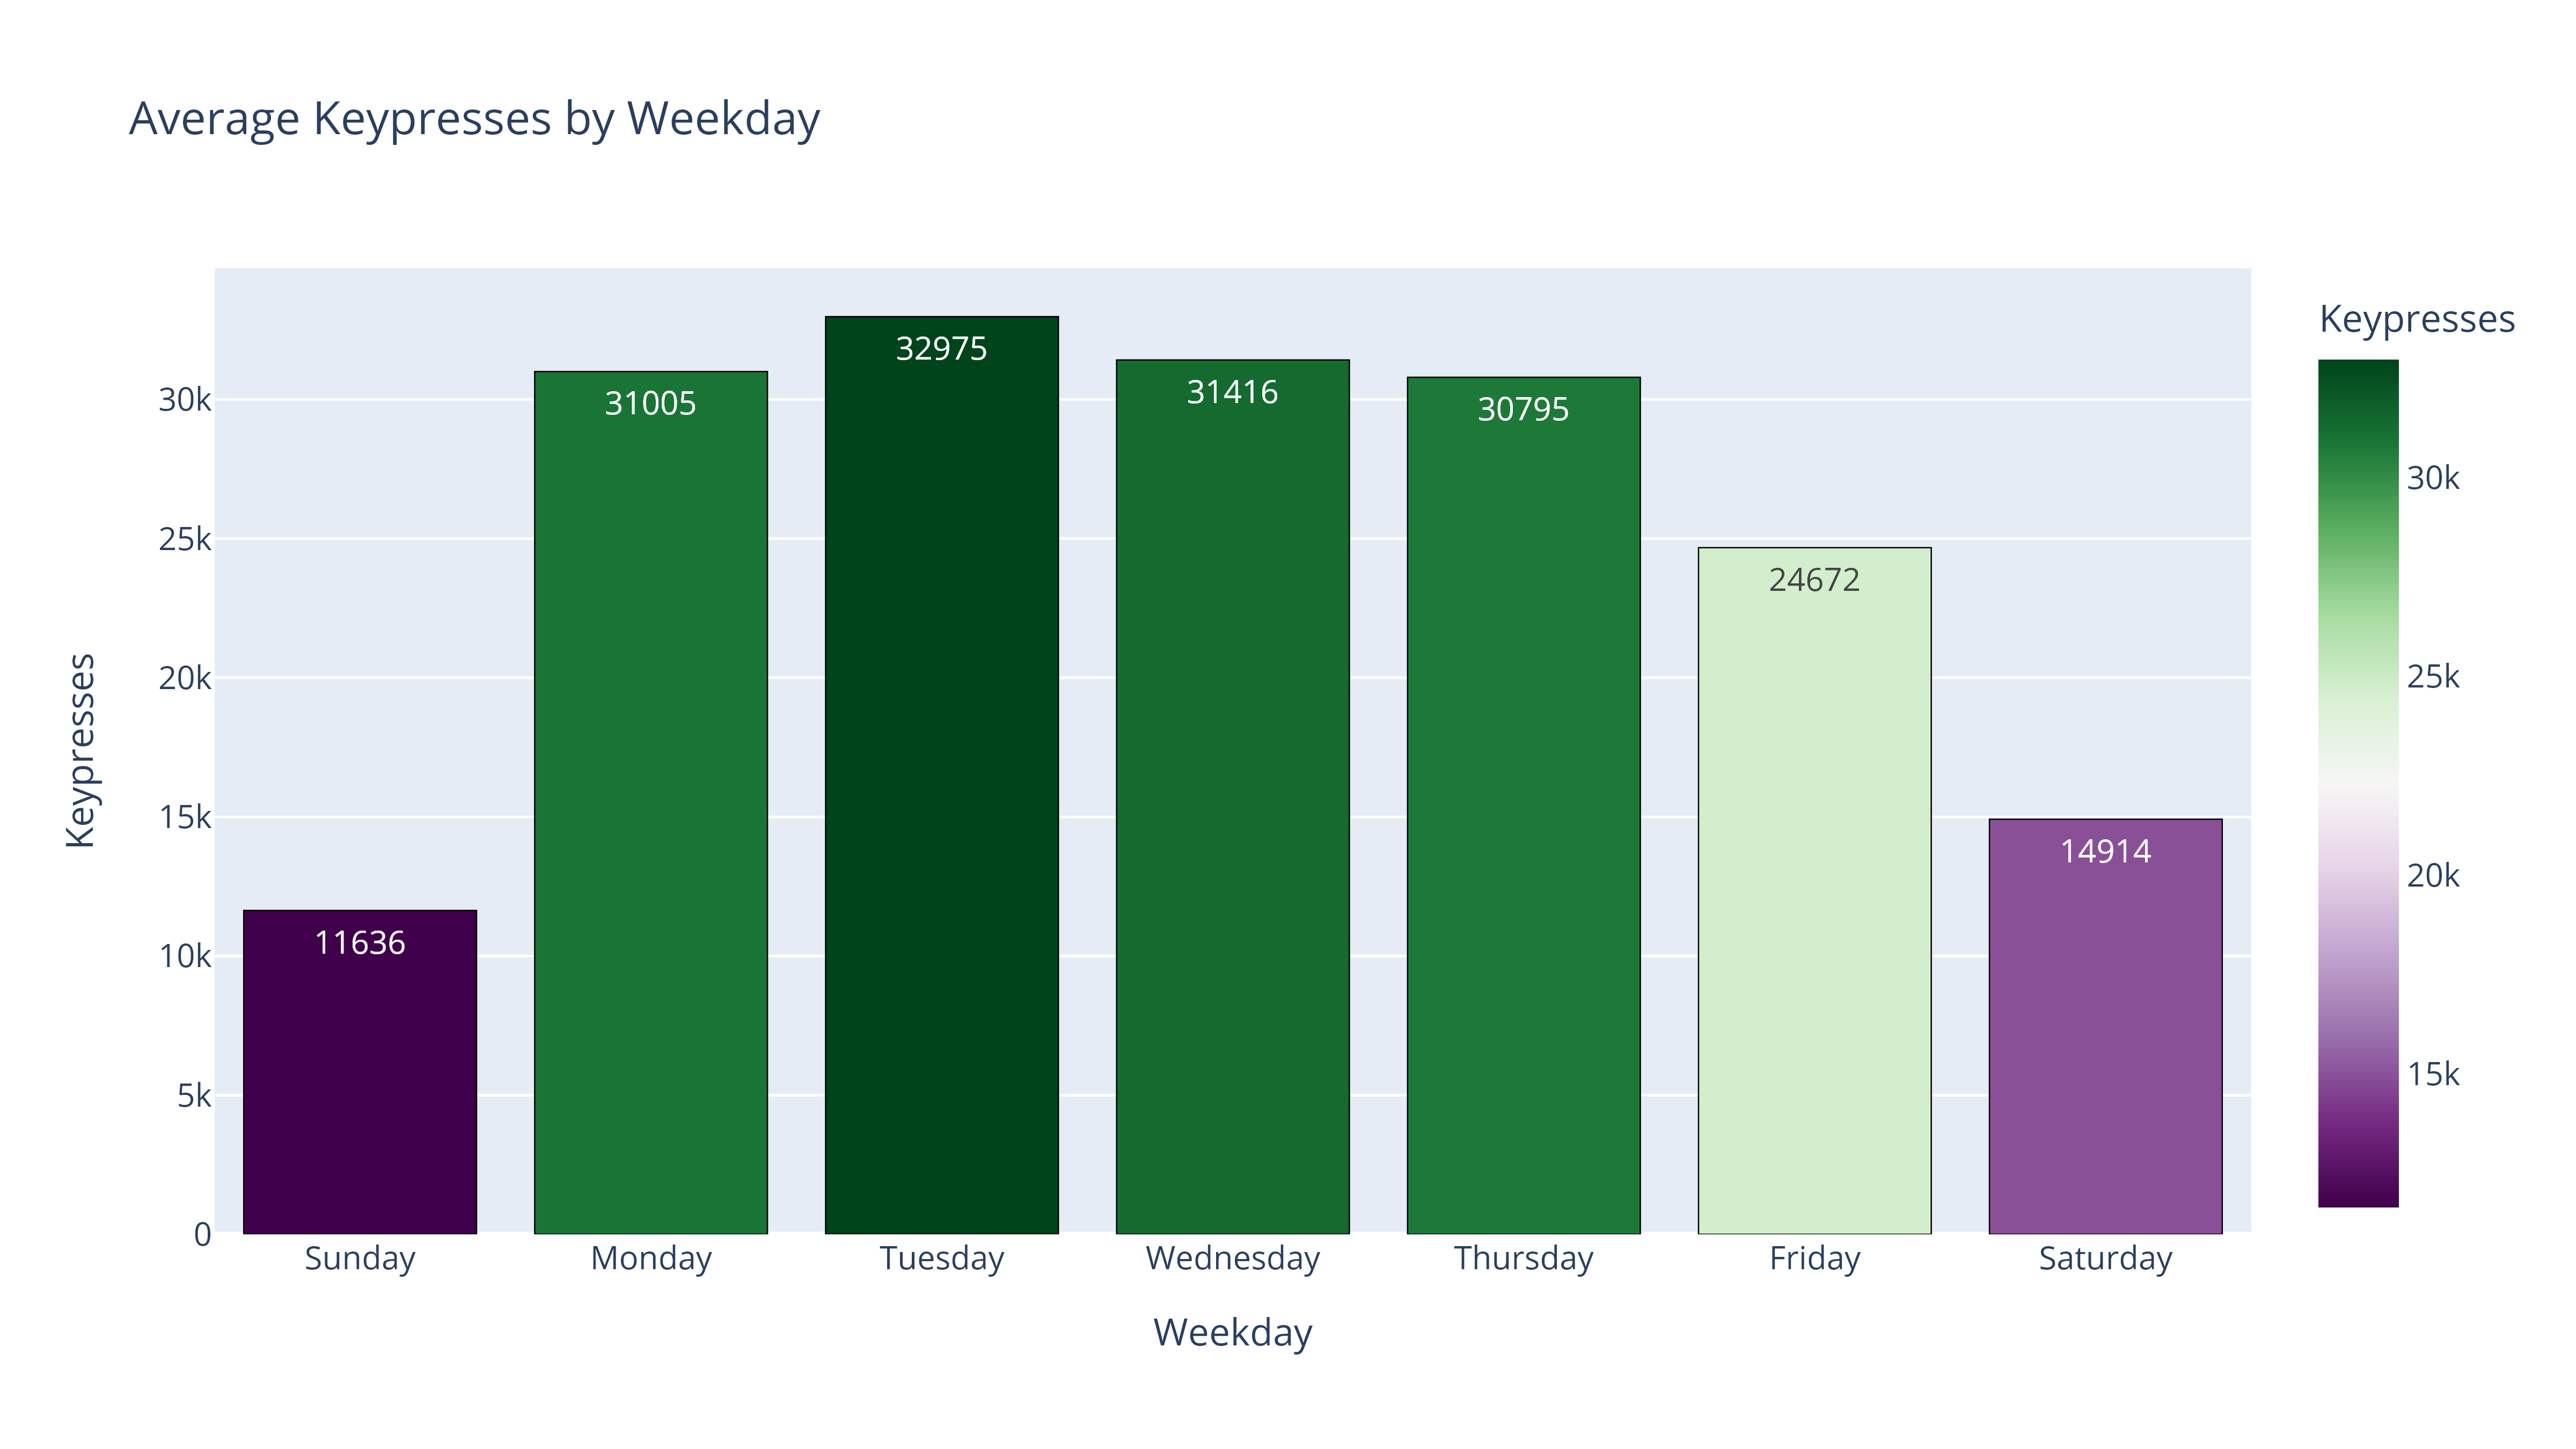

In [28]:
Image(static_graphs_folder+'keypresses_by_weekday.png')

### Total keypresses since first date in DataFrame:

In [29]:
print("Total keypresess since", str(
df_combined_daily_keypresses.iloc[0]['Date'])+":",'{:,}'.format(
sum(df_combined_daily_keypresses['Keypresses'])))

Total keypresess since 2020-09-21 00:00:00: 32,277,312


### Keypresses over the past 50 days:

In [30]:
df_combined_daily_keypresses.tail(50) # Last 50 days

Date  Keypresses      7_day_ma     28_day_ma    365_day_ma  \
1223 2024-01-27           0  22625.142857  34161.964286  26284.336986   
1224 2024-01-28        5283  22415.714286  33982.107143  26279.671233   
1225 2024-01-29        8541  18517.285714  33549.000000  26283.747945   
1226 2024-01-30        3336  12223.285714  30859.464286  26184.572603   
1227 2024-01-31        2201   2765.857143  27567.357143  26117.723288   
1228 2024-02-01           0   2765.857143  27149.500000  26009.164384   
1229 2024-02-02       13198   4651.285714  25718.678571  26029.260274   
1230 2024-02-03       11912   6353.000000  25658.892857  26028.054795   
1231 2024-02-04       23617   8972.142857  25994.714286  26072.178082   
1232 2024-02-05        1250   7930.571429  21688.178571  26073.361644   
1233 2024-02-06         769   7563.857143  20954.178571  26034.246575   
1234 2024-02-07        3313   7722.714286  19823.321429  25960.608219   
1235 2024-02-08        8530   8941.285714  18457.428571  25908.405479   
1236 2024-02-09        2008   7342.714286  16280.107143  25819.479452   
1237 2024-02-10        4549   6290.857143  16216.678571  25750.994521   
1238 2024-02-11       18544   5566.142857  16719.428571  25799.213699   
1239 2024-02-12        6709   6346.000000  16628.285714  25808.572603   
1240 2024-02-13       22280   9419.000000  16351.607143  25819.561644   
1241 2024-02-14           5   8946.428571  15423.607143  25781.564384   
1242 2024-02-15        3052   8163.857143  13496.000000  25746.882192   
1243 2024-02-16       12496   9662.142857  12791.071429  25670.002740   
1244 2024-02-17       31923  13572.714286  12210.428571  25624.249315   
1245 2024-02-18        2512  11282.428571  12059.107143  25579.504110   
1246 2024-02-19       13534  12257.428571  11262.821429  25611.495890   
1247 2024-02-20       13287  10972.714286  10044.714286  25642.627397   
1248 2024-02-21       43274  17154.000000   9147.250000  25662.504110   
1249 2024-02-22       16772  19114.000000   9746.250000  25604.808219   
1250 2024-02-23       31806  21872.571429  10882.178571  25557.430137   
1251 2024-02-24       19710  20127.857143  11586.107143  25519.690411   
1252 2024-02-25           0  19769.000000  11397.428571  25491.156164   
1253 2024-02-26        2595  18206.285714  11185.071429  25498.265753   
1254 2024-02-27        1567  16532.000000  11121.892857  25431.328767   
1255 2024-02-28       57119  18509.857143  13083.250000  25531.758904   
1256 2024-02-29       25710  19786.714286  14001.464286  25505.895890   
1257 2024-03-01         899  15371.428571  13562.214286  25386.567123   
1258 2024-03-02          25  12559.285714  13137.678571  25382.693151   
1259 2024-03-03          62  12568.142857  12296.428571  25382.863014   
1260 2024-03-04        6785  13166.714286  12494.107143  25355.764384   
1261 2024-03-05       40987  18798.142857  13930.464286  25359.684932   
1262 2024-03-06       50175  17806.142857  15604.107143  25417.536986   
1263 2024-03-07        3366  14614.142857  15419.678571  25332.695890   
1264 2024-03-08        1723  14731.857143  15409.500000  25286.715068   
1265 2024-03-09       43693  20970.142857  16807.500000  25317.641096   
1266 2024-03-10         111  20977.142857  16149.178571  25273.569863   
1267 2024-03-11       59669  28532.000000  18040.607143  25380.912329   
1268 2024-03-12       65458  32027.857143  19582.678571  25437.578082   
1269 2024-03-13       57509  33075.571429  21636.392857  25499.835616   
1270 2024-03-14       67124  42183.857143  23924.678571  25595.394521   
1271 2024-03-15       36963  47218.142857  24798.500000  25619.561644   
1272 2024-03-16       29865  45242.714286  24725.000000  25655.810959   

      percentile    rank    Weekday  
1223    2.906520  1237.0   Saturday  
1224   19.167321  1030.0     Sunday  
1225   24.587588   961.0     Monday  
1226   16.653574  1062.0    Tuesday  
1227   14.296936  1092.0  Wednesday  
1228    2.906520  1237.0   Thursday  
1229   31.029065   87

The following cell outputs various keypress statistics. When this script is run hourly, these statistics (along with other ones) will then appear in the console terminal.

In [31]:
days_with_data = len(df_combined_daily_keypresses)
#  The following column cell shows the ranks immediately above the ranks for the most recent day.
keypresses_today = df_combined_daily_keypresses.iloc[-1]['Keypresses']
percentile_today = df_combined_daily_keypresses.iloc[-1]['percentile']
rank_today = df_combined_daily_keypresses.iloc[-1]['rank']
print("Ranks are out of", days_with_data, "days.")
print(f"Today's keypresses: {keypresses_today}")
print(f"Your keypress totals yesterday and 7, 28, and 365 days ago were \
{df_combined_daily_keypresses.iloc[-2]['Keypresses']}, \
{df_combined_daily_keypresses.iloc[-8]['Keypresses']}, \
{df_combined_daily_keypresses.iloc[-29]['Keypresses']}, \
and {df_combined_daily_keypresses.iloc[-366]['Keypresses']}, respectively.")
# If your keypresses today are higher than these values, the moving averages
# associated with those values will increase.
print(f"Today's percentile: {round(percentile_today, 3)}")
print(f"Today's rank: {rank_today} \
(in front of {days_with_data - rank_today} days)")

Ranks are out of 1273 days.
Today's keypresses: 29865
Your keypress totals yesterday and 7, 28, and 365 days ago were 36963, 43693, 31923, and 16634, respectively.
Today's percentile: 59.859
Today's rank: 512.0 (in front of 761.0 days)


Days ranked just ahead of today (along with today's rank):

In [32]:
df_days_with_higher_keypresses = df_combined_daily_keypresses.sort_values(
    'rank').query("rank <= @rank_today").tail(11)
keypress_difference_list = [df_days_with_higher_keypresses.iloc[i][
    'Keypresses'] - df_days_with_higher_keypresses.iloc[i+1][
        'Keypresses'] for i in range(len(df_days_with_higher_keypresses) -1 )]
keypress_difference_list.append(np.NaN)
df_days_with_higher_keypresses[
    'diff_from_following_day'] = keypress_difference_list
df_days_with_higher_keypresses[
    'diff_from_current_day'] = df_days_with_higher_keypresses[
        'Keypresses'] - df_days_with_higher_keypresses.iloc[-1]['Keypresses']
df_days_with_higher_keypresses

Date  Keypresses      7_day_ma     28_day_ma    365_day_ma  \
1026 2023-07-14       30171  18003.857143  16546.821429  20932.805479   
547  2022-03-22       30165  10191.857143  11713.392857  24423.895890   
578  2022-04-22       30101  24341.857143  29521.500000  23799.232877   
1173 2023-12-08       30078  52329.428571  44081.750000  23996.997260   
1212 2024-01-16       30027  27829.285714  35886.607143  26081.838356   
343  2021-08-30       30002  13560.857143  22669.000000           NaN   
436  2021-12-01       29954  21674.571429  27999.821429  28964.024658   
1148 2023-11-13       29944  31486.285714  27291.928571  22814.586301   
120  2021-01-19       29922  22547.285714  18311.178571           NaN   
737  2022-09-28       29908  18806.000000  11800.107143  21618.230137   
1272 2024-03-16       29865  45242.714286  24725.000000  25655.810959   

      percentile   rank    Weekday  diff_from_following_day  \
1026   60.644148  502.0     Friday                      6.0   
547    60.565593  503.0    Tuesday                     64.0   
578    60.487038  504.0     Friday                     23.0   
1173   60.408484  505.0     Friday                     51.0   
1212   60.329929  506.0    Tuesday                     25.0   
343    60.251375  507.0     Monday                     48.0   
436    60.172820  508.0  Wednesday                     10.0   
1148   60.094266  509.0     Monday                     22.0   
120    60.015711  510.0    Tuesday                     14.0   
737    59.937156  511.0  Wednesday                     43.0   
1272   59.858602  512.0   Saturday                      NaN   

      diff_from_current_day  
1026                    306  
547                     300  
578                     236  
1173                    213  
1212                    162  
343                     137  
436                      89  
1148                     79  
120                      57  
737                      43  
1272                      0

Looking for days with identical non-zero keypress totals:

In [33]:
duplicated_keypress_dates = df_combined_daily_keypresses[
df_combined_daily_keypresses.duplicated(
subset = 'Keypresses', keep = False)].query('Keypresses > 0').sort_values(
'Keypresses', ascending = False)
len(duplicated_keypress_dates)

24

In [34]:
duplicated_keypress_dates

Date  Keypresses      7_day_ma     28_day_ma    365_day_ma  \
32   2020-10-23       48908  41125.571429  37996.178571           NaN   
183  2021-03-23       48908  36708.000000  32516.464286           NaN   
315  2021-08-02       42704  30582.285714  29370.714286           NaN   
1071 2023-08-28       42704  28179.142857  24481.535714  21111.791781   
1218 2024-01-22       35830  33719.285714  34827.642857  26308.213699   
746  2022-10-07       35830  22178.714286  14628.250000  21042.265753   
3    2020-09-24       34698           NaN           NaN           NaN   
124  2021-01-23       34698  34726.428571  24214.178571           NaN   
318  2021-08-05       32184  29066.857143  29787.500000           NaN   
676  2022-07-29       32184  26384.571429  26299.000000  23180.561644   
1244 2024-02-17       31923  13572.714286  12210.428571  25624.249315   
525  2022-02-28       31923  18683.142857  17425.357143  25764.104110   
687  2022-08-09       26905  21784.571429  25372.785714  22972.580822   
765  2022-10-26       26905  25745.714286  20627.357143  20359.476712   
645  2022-06-28       26550  12407.857143  12670.821429  23373.895890   
55   2020-11-15       26550  36325.285714  35269.428571           NaN   
662  2022-07-15       25084  28583.714286  18304.428571  23319.049315   
841  2023-01-10       25084  16131.571429  16824.607143  21120.632877   
620  2022-06-03       23824  18572.857143  19212.571429  23844.123288   
1050 2023-08-07       23824  17324.000000  23705.250000  20797.142466   
321  2021-08-08        6318  30379.714286  30359.035714           NaN   
632  2022-06-15        6318   6218.571429  15957.071429  23702.145205   
538  2022-03-13         149   8908.285714  15542.392857  25160.463014   
536  2022-03-11         149  10365.285714  15863.214286  25284.586301   

      percentile    rank    Weekday  
32     89.198743   138.5     Friday  
183    89.198743   138.5    Tuesday  
315    82.364493   225.5     Monday  
1071   82.364493   225.5     Monday  
1218   71.052632   369.5     Monday  
746    71.052632   369.5     Friday  
3      69.010212   395.5   Thursday  
124    69.010212   395.5   Saturday  
318    64.532600   452.5   Thursday  
676    64.532600   452.5     Friday  
1244   63.668500   463.5   Saturday  
525    63.668500   463.5     Monday  
687    54.791830   576.5    Tuesday  
765    54.791830   576.5  Wednesday  
645    53.927730   587.5    Tuesday  
55     53.927730   587.5     Sunday  
662    50.628437   629.5     Friday  
841    50.628437   629.5    Tuesday  
620    48.428908   657.5     Friday  
1050   48.428908   657.5     Monday  
321    21.013354  1006.5     Sunday  
632    21.013354  1006.5  Wednesday  
538     7.580518  1177.5     Sunday  
536     7.580518  1177.5     Friday

In [35]:
df_combined_daily_keypresses

Date  Keypresses      7_day_ma     28_day_ma    365_day_ma  \
0    2020-09-21       19081           NaN           NaN           NaN   
1    2020-09-22       32771           NaN           NaN           NaN   
2    2020-09-23       32065           NaN           NaN           NaN   
3    2020-09-24       34698           NaN           NaN           NaN   
4    2020-09-25       47038           NaN           NaN           NaN   
...         ...         ...           ...           ...           ...   
1268 2024-03-12       65458  32027.857143  19582.678571  25437.578082   
1269 2024-03-13       57509  33075.571429  21636.392857  25499.835616   
1270 2024-03-14       67124  42183.857143  23924.678571  25595.394521   
1271 2024-03-15       36963  47218.142857  24798.500000  25619.561644   
1272 2024-03-16       29865  45242.714286  24725.000000  25655.810959   

      percentile   rank    Weekday  
0      40.298507  761.0     Monday  
1      65.514533  440.0    Tuesday  
2      64.179104  457.0  Wednesday  
3      69.010212  395.5   Thursday  
4      87.274156  163.0     Friday  
...          ...    ...        ...  
1268   97.800471   29.0    Tuesday  
1269   94.658288   69.0  Wednesday  
1270   98.350353   22.0   Thursday  
1271   73.448547  339.0     Friday  
1272   59.858602  512.0   Saturday  

[1273 rows x 8 columns]

In [36]:
df_combined_daily_keypresses['Date']

0      2020-09-21
1      2020-09-22
2      2020-09-23
3      2020-09-24
4      2020-09-25
          ...    
1268   2024-03-12
1269   2024-03-13
1270   2024-03-14
1271   2024-03-15
1272   2024-03-16
Name: Date, Length: 1273, dtype: datetime64[ns]

## Plotting Chronological Keypress Data

Now that we have a DataFrame showing daily keypresses and multiple moving averages, it's time to visualize it! The advantage of creating this chart within Plotly is that, being HTML-based, it is interactive in nature. Thus, you can hover over the lines to view the values corresponding to those lines and zoom in to get a closer look at a particular section of the graph. As before, though, this graph can also be saved as a static image.

In [37]:
fig_keypresses_line_chart = px.line(df_combined_daily_keypresses, x = 'Date', 
y = ['Keypresses', '7_day_ma', '28_day_ma', '365_day_ma'],
labels = {'variable':'Metric','value':'Keypresses'}, title = 
'Daily Keypresses and 7/28/365-day Moving Averages') 
# Note that multiple y values can be passed to the line chart. 

save_chart(fig_keypresses_line_chart, 'px_daily_keypresses_and_mas')

fig_keypresses_line_chart

c:\Users\kburc\miniforge3\envs\ga15pyd\lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



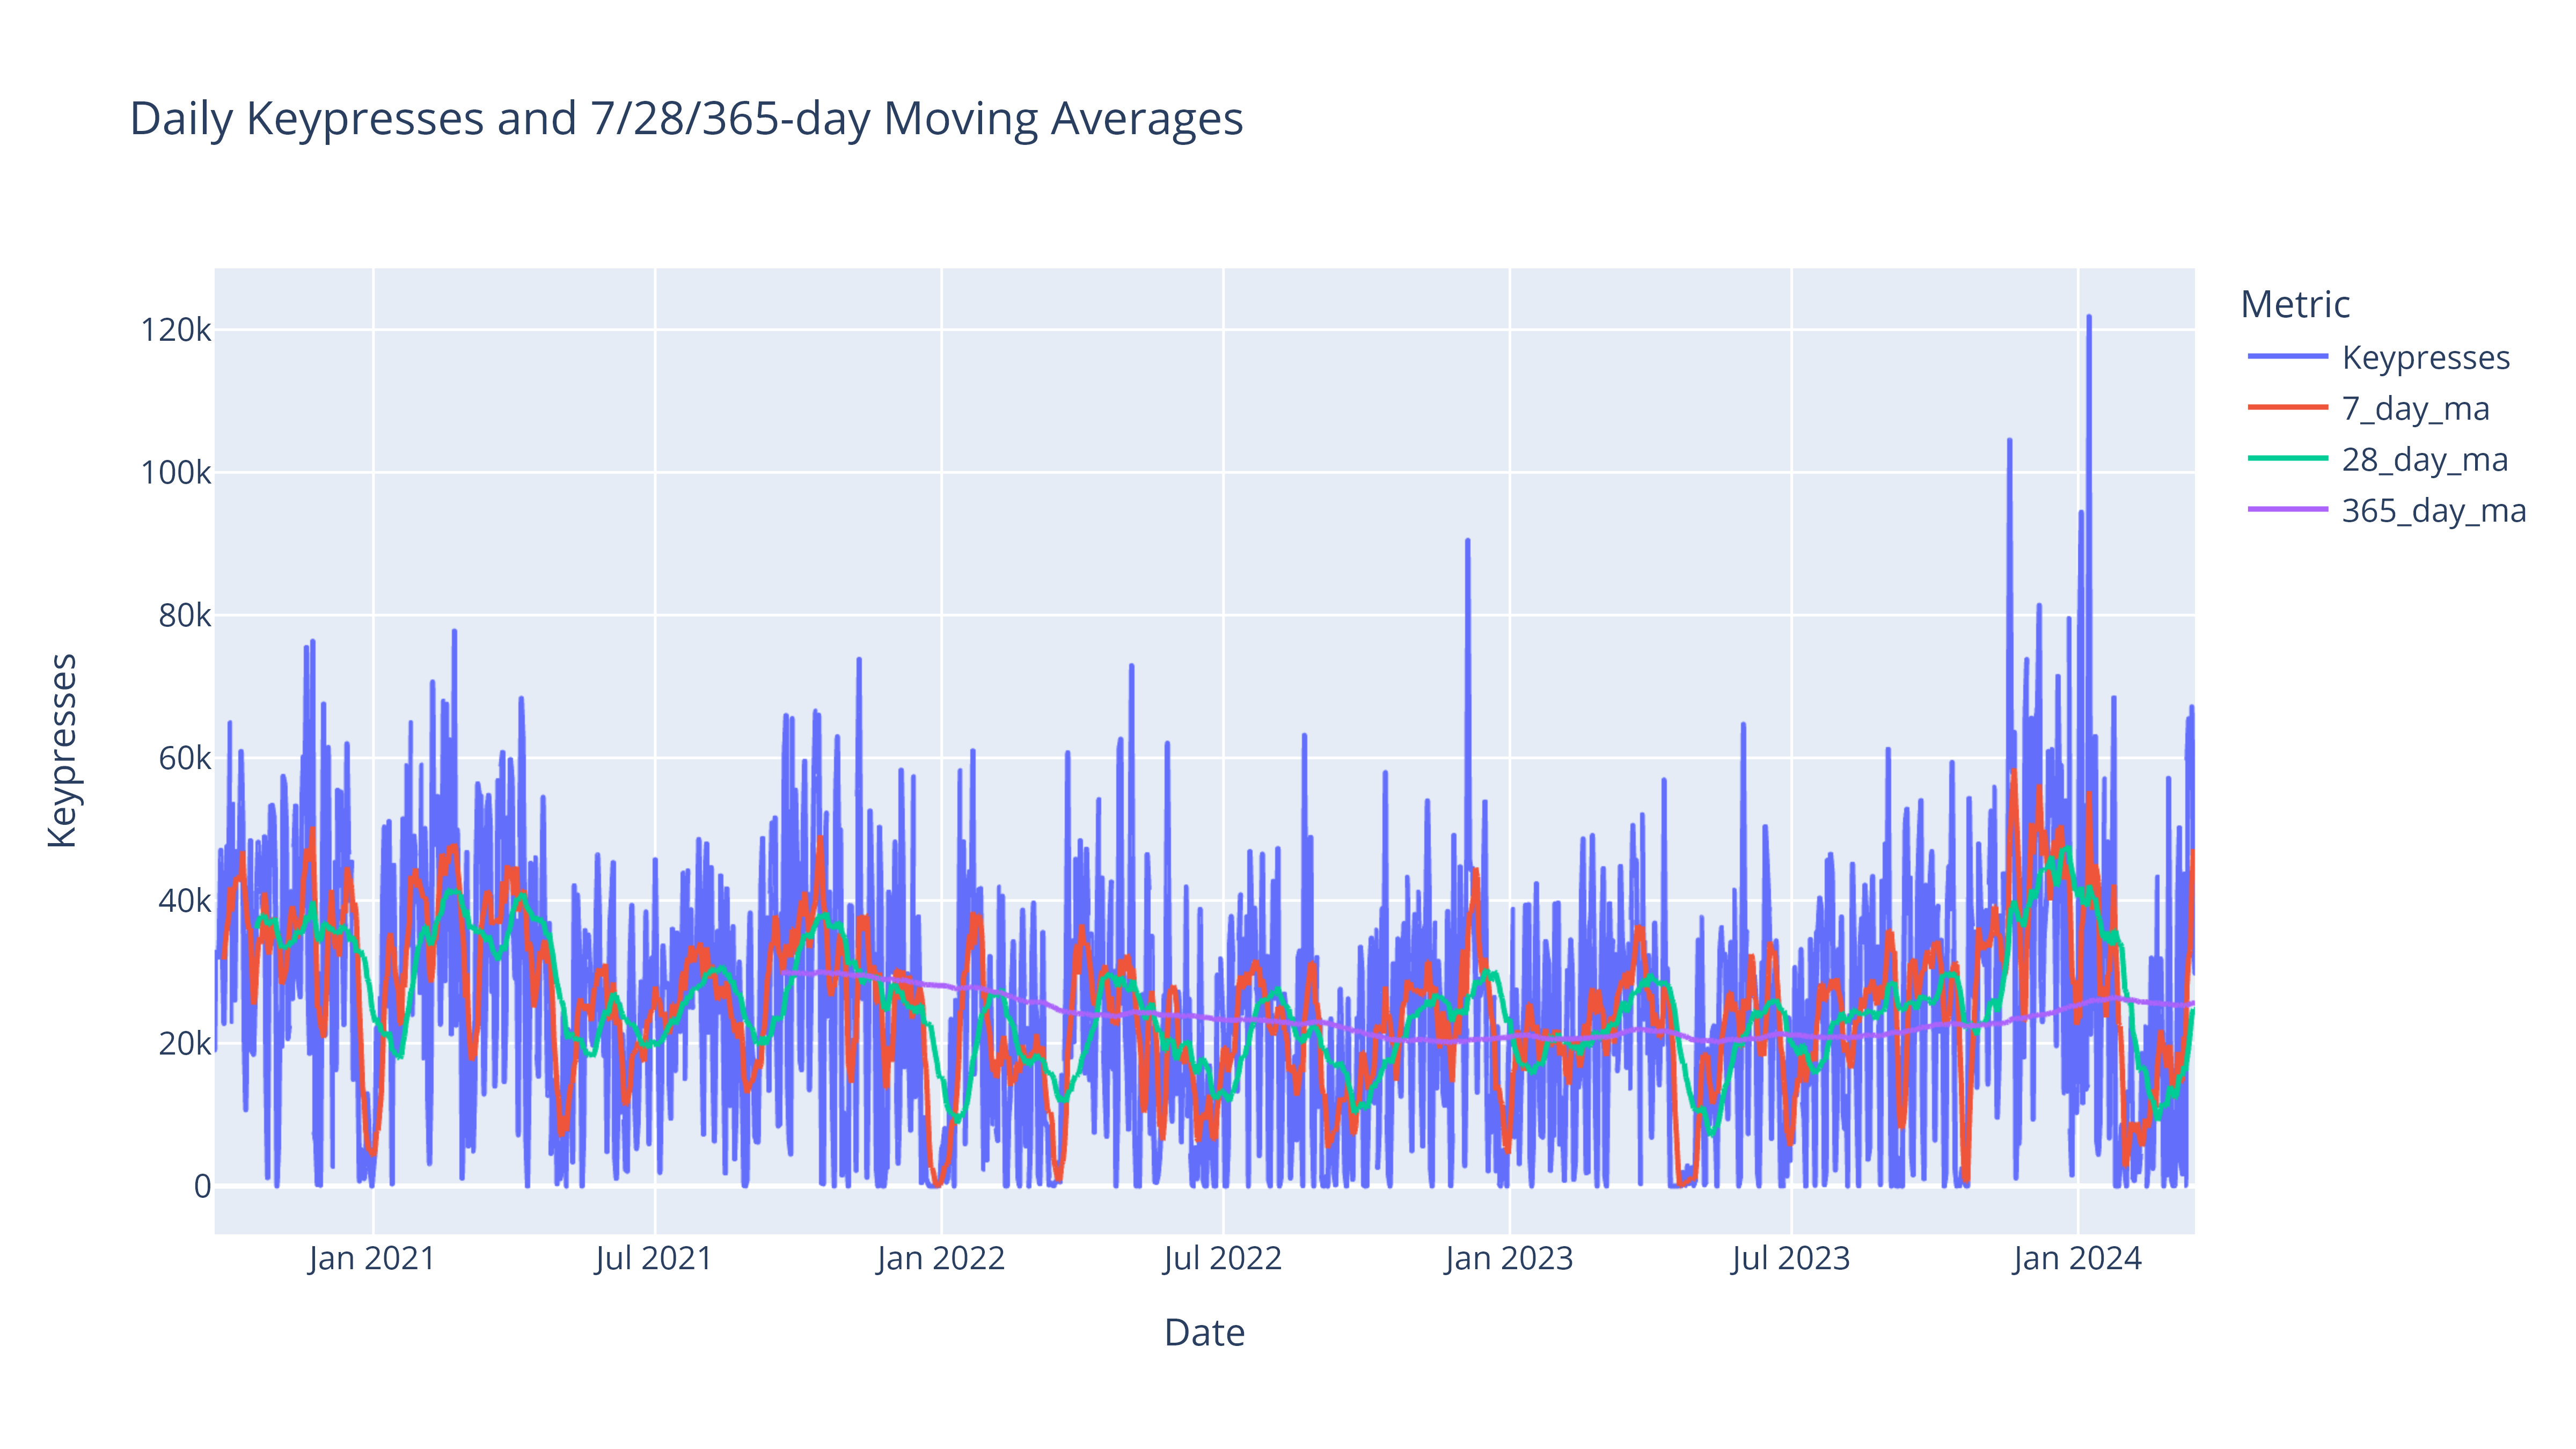

In [38]:
Image(static_graphs_folder+'px_daily_keypresses_and_mas.png')

## Monthly keypress totals:

In [39]:
df_monthly_keypresses = df_combined_daily_keypresses.copy().set_index(
    'Date').resample('M').sum()['Keypresses'].reset_index()
df_monthly_keypresses['Month'] = df_monthly_keypresses['Date'].dt.to_period('M')
df_monthly_keypresses['Year'] = df_monthly_keypresses['Date'].dt.to_period('Y')
df_monthly_keypresses.drop('Date', axis = 1, inplace = True)
df_monthly_keypresses['Keypresses'] = df_monthly_keypresses.pop('Keypresses')
df_monthly_keypresses

C:\Users\kburc\AppData\Local\Temp\ipykernel_31088\3726139356.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



Month  Year  Keypresses
0   2020-09  2020      346918
1   2020-10  2020     1140421
2   2020-11  2020     1061614
3   2020-12  2020      823763
4   2021-01  2021      980116
5   2021-02  2021     1088404
6   2021-03  2021     1142850
7   2021-04  2021      833464
8   2021-05  2021      700155
9   2021-06  2021      621894
10  2021-07  2021      881137
11  2021-08  2021      722970
12  2021-09  2021      919571
13  2021-10  2021     1051663
14  2021-11  2021      797115
15  2021-12  2021      515936
16  2022-01  2022      729233
17  2022-02  2022      487910
18  2022-03  2022      552559
19  2022-04  2022      834250
20  2022-05  2022      627263
21  2022-06  2022      412725
22  2022-07  2022      758759
23  2022-08  2022      691636
24  2022-09  2022      330566
25  2022-10  2022      706081
26  2022-11  2022      756509
27  2022-12  2022      720251
28  2023-01  2023      652155
29  2023-02  2023      580208
30  2023-03  2023      892786
31  2023-04  2023      327674
32  2023-05  2023      665769
33  2023-06  2023      628301
34  2023-07  2023      694009
35  2023-08  2023      809682
36  2023-09  2023      803639
37  2023-10  2023      715687
38  2023-11  2023     1156827
39  2023-12  2023     1292810
40  2024-01  2024      965577
41  2024-02  2024      392041
42  2024-03  2024      464414

# Saving the updated version of this DataFrame to a .csv file:

In [40]:
df_combined_daily_keypresses.to_csv(
    'data/df_combined_daily_keypresses_updated.csv')

## Hourly keypress stats:

In order to calculate hourly keypress statistics, we'll need to create a new DataFrame that aggregates keypresses by hour instead of by day.

In [41]:
hourly_keypress_db_list = []

for db_path in database_paths_list:
    hourly_keypress_db_list.append(generate_keypress_totals(
        database_path = db_path, level = 'hourly'))

df_hourly_keypresses = pd.concat([
    df for df in hourly_keypress_db_list]).reset_index(drop=True)

# As with my daily keypresess DataFrame, I'll use pivot_table() to group 
# multiple rows for the same day and hour into a single row. (These multiple 
# rows are the result of my using multiple computers during the same hour.)
df_hourly_keypresses = df_hourly_keypresses.pivot_table(index = [
    'Day', 'Hour'], values = 'Keypresses', aggfunc = 'sum').reset_index().sort_values(['Day', 'Hour'])

df_hourly_keypresses.to_csv(
    'data/df_combined_hourly_keypresses.csv', index = False)
df_hourly_keypresses

Day  Hour  Keypresses
0      2020-09-21    15         278
1      2020-09-21    16         567
2      2020-09-21    17        1218
3      2020-09-21    18        3300
4      2020-09-21    19        3888
...           ...   ...         ...
14177  2024-03-16    13         862
14178  2024-03-16    14        6321
14179  2024-03-16    15        4146
14180  2024-03-16    16         494
14181  2024-03-16    17        1984

[14182 rows x 3 columns]

Recreating the DataFrame from a .csv file so that the following cells can be run by users who don't yet have their own WhatPulse database:

In [42]:
df_hourly_keypresses = pd.read_csv('data/df_combined_hourly_keypresses.csv')


In [43]:
df_hourly_keypresses['Day'] = pd.to_datetime(df_hourly_keypresses['Day'])
# Creating a combined day/hour column:
df_hourly_keypresses['Day_and_Hour'] = df_hourly_keypresses[
    'Day'] + pd.to_timedelta(df_hourly_keypresses['Hour'], unit = 'H')
df_hourly_keypresses.set_index('Day_and_Hour', inplace = True)
df_hourly_keypresses

C:\Users\kburc\AppData\Local\Temp\ipykernel_31088\137757146.py:4: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.



Day  Hour  Keypresses
Day_and_Hour                                    
2020-09-21 15:00:00 2020-09-21    15         278
2020-09-21 16:00:00 2020-09-21    16         567
2020-09-21 17:00:00 2020-09-21    17        1218
2020-09-21 18:00:00 2020-09-21    18        3300
2020-09-21 19:00:00 2020-09-21    19        3888
...                        ...   ...         ...
2024-03-16 13:00:00 2024-03-16    13         862
2024-03-16 14:00:00 2024-03-16    14        6321
2024-03-16 15:00:00 2024-03-16    15        4146
2024-03-16 16:00:00 2024-03-16    16         494
2024-03-16 17:00:00 2024-03-16    17        1984

[14182 rows x 3 columns]

The following cells add in hours with 0 keypresses (of which there are many!). In order to include current/previous hours for the current day in my results, I'll add in keypresses up to the start of the next day (i.e. midnight), then limit the results so that they don't extend beyond the current hour.

Calculating tomorrow's date:

In [44]:
last_date_for_hourly_keypress_log = last_date + datetime.timedelta(days = 1)
last_date_for_hourly_keypress_log

Timestamp('2024-03-17 00:00:00')

In [45]:
pd.Timestamp.now()

Timestamp('2024-03-16 17:44:35.253021')

Adding hours without keypresses to the DataFrame:

In [46]:
full_hourly_date_range = pd.date_range(start = first_date, 
end = last_date_for_hourly_keypress_log, freq = 'h')
df_hourly_keypresses = df_hourly_keypresses.reindex(full_hourly_date_range).copy()
df_hourly_keypresses['Keypresses'] = df_hourly_keypresses['Keypresses'].fillna(0)
df_hourly_keypresses['Keypresses'] = df_hourly_keypresses[
    'Keypresses'].astype('int')
# Retrieving date and hour values from the index:
df_hourly_keypresses['Day'] = df_hourly_keypresses.index.date
df_hourly_keypresses['Hour'] = df_hourly_keypresses.index.hour
df_hourly_keypresses

Day  Hour  Keypresses
2020-09-21 00:00:00  2020-09-21     0           0
2020-09-21 01:00:00  2020-09-21     1           0
2020-09-21 02:00:00  2020-09-21     2           0
2020-09-21 03:00:00  2020-09-21     3           0
2020-09-21 04:00:00  2020-09-21     4           0
...                         ...   ...         ...
2024-03-16 20:00:00  2024-03-16    20           0
2024-03-16 21:00:00  2024-03-16    21           0
2024-03-16 22:00:00  2024-03-16    22           0
2024-03-16 23:00:00  2024-03-16    23           0
2024-03-17 00:00:00  2024-03-17     0           0

[30553 rows x 3 columns]

Limiting the results to the period leading up to the current hour:

In [47]:
df_hourly_keypresses = df_hourly_keypresses[
    df_hourly_keypresses.index < pd.Timestamp.now()].copy()
df_hourly_keypresses.reset_index(drop=True,inplace=True)

Calculating rolling 24-hour keypress totals:

In [48]:
df_hourly_keypresses['keypresses_over_last_24_hours'] = df_hourly_keypresses[
    'Keypresses'].rolling(24).sum()
df_hourly_keypresses

Day  Hour  Keypresses  keypresses_over_last_24_hours
0      2020-09-21     0           0                            NaN
1      2020-09-21     1           0                            NaN
2      2020-09-21     2           0                            NaN
3      2020-09-21     3           0                            NaN
4      2020-09-21     4           0                            NaN
...           ...   ...         ...                            ...
30541  2024-03-16    13         862                        30418.0
30542  2024-03-16    14        6321                        34399.0
30543  2024-03-16    15        4146                        34674.0
30544  2024-03-16    16         494                        31006.0
30545  2024-03-16    17        1984                        29926.0

[30546 rows x 4 columns]

Printing out recent hours with keypresses: (This data will also appear on the terminal window when the program is run automatically, which allows you to track your recent productivity.)

In [49]:
print("Keypresses over the last 25 hours (excluding hours \
with 0 keypresses):\n",df_hourly_keypresses.iloc[-25:].query("Keypresses > 0"))
# Hours with 0 keypresses are removed in order to give the console output more
# space to fit on a single line.

Keypresses over the last 25 hours (excluding hours with 0 keypresses):
               Day  Hour  Keypresses  keypresses_over_last_24_hours
30521  2024-03-15    17        3064                        52104.0
30522  2024-03-15    18          46                        45687.0
30525  2024-03-15    21          13                        45685.0
30527  2024-03-15    23           2                        36963.0
30538  2024-03-16    10       10299                        30907.0
30539  2024-03-16    11        5759                        34227.0
30541  2024-03-16    13         862                        30418.0
30542  2024-03-16    14        6321                        34399.0
30543  2024-03-16    15        4146                        34674.0
30544  2024-03-16    16         494                        31006.0
30545  2024-03-16    17        1984                        29926.0


Keypresses for the last 48 hours (including hours with 0 keypresses, now that they have been added to our table):

In [50]:
df_hourly_keypresses.iloc[-48:]

Day  Hour  Keypresses  keypresses_over_last_24_hours
30498  2024-03-14    18        6463                        74825.0
30499  2024-03-14    19           0                        74825.0
30500  2024-03-14    20           0                        72918.0
30501  2024-03-14    21          15                        66384.0
30502  2024-03-14    22        3610                        66097.0
30503  2024-03-14    23        5114                        67124.0
30504  2024-03-15     0         249                        65632.0
30505  2024-03-15     1           0                        64526.0
30506  2024-03-15     2           0                        64526.0
30507  2024-03-15     3           0                        64526.0
30508  2024-03-15     4           0                        64526.0
30509  2024-03-15     5           0                        64526.0
30510  2024-03-15     6           0                        64526.0
30511  2024-03-15     7           0                        64526.0
30512  2024-03-15     8           0                        53658.0
30513  2024-03-15     9       12936                        65303.0
30514  2024-03-15    10        3170                        64206.0
30515  2024-03-15    11        2439                        61167.0
30516  2024-03-15    12        3155                        58484.0
30517  2024-03-15    13        1516                        59214.0
30518  2024-03-15    14        2340                        54766.0
30519  2024-03-15    15        3871                        53178.0
30520  2024-03-15    16        4162                        50036.0
30521  2024-03-15    17        3064                        52104.0
30522  2024-03-15    18          46                        45687.0
30523  2024-03-15    19           0                        45687.0
30524  2024-03-15    20           0                        45687.0
30525  2024-03-15    21          13                        45685.0
30526  2024-03-15    22           0                        42075.0
30527  2024-03-15    23           2                        36963.0
30528  2024-03-16     0           0                        36714.0
30529  2024-03-16     1           0                        36714.0
30530  2024-03-16     2           0                        36714.0
30531  2024-03-16     3           0                        36714.0
30532  2024-03-16     4           0                        36714.0
30533  2024-03-16     5           0                        36714.0
30534  2024-03-16     6           0                        36714.0
30535  2024-03-16     7           0                        36714.0
30536  2024-03-16     8           0                        36714.0
30537  2024-03-16     9           0                        23778.0
30538  2024-03-16    10       10299                        30907.0
30539  2024-03-16    11        5759                        34227.0
30540  2024-03-16    12           0                        31072.0
30541  2024-03-16    13         862                        30418.0
30542  2024-03-16    14        6321                        34399.0
30543  2024-03-16    15        4146                        34674.0
30544  2024-03-16    16         494                        31006.0
30545  2024-03-16    17        1984                        29926.0

Making sure that all rows with the same day and hour (e.g. from multiple WhatPulse databases) have been merged into the same row:

In [51]:
df_hourly_keypresses[df_hourly_keypresses.duplicated(
    subset = ['Day', 'Hour'], keep = False)]

Empty DataFrame
Columns: [Day, Hour, Keypresses, keypresses_over_last_24_hours]
Index: []

Most keypresses typed in a single hour within the entire dataset:

In [52]:
df_top_hourly_keypresses = df_hourly_keypresses.sort_values('Keypresses', ascending = False).head(50).copy()
df_top_hourly_keypresses['Day and Hour'] = (
df_top_hourly_keypresses['Day'].astype('str') + ' ' +
df_top_hourly_keypresses['Hour'].astype('str'))
df_top_hourly_keypresses

Day  Hour  Keypresses  keypresses_over_last_24_hours  \
28799  2024-01-03    23       43726                        94380.0   
28390  2023-12-17    22       38627                        39714.0   
28558  2023-12-24    22       38424                        43794.0   
27685  2023-11-18    13       37609                        62428.0   
27543  2023-11-12    15       34112                        45511.0   
30274  2024-03-05    10       32901                        44898.0   
27211  2023-10-29    19       31340                        42575.0   
27713  2023-11-19    17       30905                        79732.0   
28584  2023-12-26     0       29522                        42802.0   
27378  2023-11-05    18       28089                        28089.0   
28482  2023-12-21    18       27957                        55127.0   
28596  2023-12-26    12       25519                        74109.0   
29196  2024-01-20    12       24115                        49887.0   
28764  2024-01-02    12       22794                        48326.0   
27864  2023-11-26     0       22455                        46258.0   
28199  2023-12-09    23       21985                        23038.0   
29856  2024-02-17     0       21746                        34242.0   
28914  2024-01-08    18       21473                        97706.0   
28029  2023-12-02    21       21077                        75054.0   
28271  2023-12-12    23       19645                        41109.0   
28216  2023-12-10    16       19210                        55219.0   
28765  2024-01-02    13       19130                        67073.0   
28918  2024-01-08    22       18512                       105967.0   
19342  2022-12-05    22       17552                        83422.0   
28913  2024-01-08    17       17262                        76233.0   
28137  2023-12-07     9       17013                        73449.0   
28433  2023-12-19    17       16879                        63734.0   
30419  2024-03-11    11       16809                        16920.0   
29760  2024-02-13     0       16774                        23483.0   
27919  2023-11-28     7       16542                        34636.0   
27695  2023-11-18    23       16448                       104525.0   
28919  2024-01-08    23       15866                       121833.0   
27993  2023-12-01     9       15575                        50349.0   
8650   2021-09-16    10       15446                        64271.0   
28026  2023-12-02    18       15286                        56203.0   
1958   2020-12-11    14       14618                        49483.0   
28200  2023-12-10     0       14024                        37062.0   
27767  2023-11-21    23       13719                        63528.0   
29728  2024-02-11    16       13641                        15438.0   
13290  2022-03-28    18       13406                        44448.0   
28679  2023-12-29    23       13351                        28345.0   
9442   2021-10-19    10       13345                        63492.0   
28583  2023-12-25    23       13280                        13314.0   
28936  2024-01-09    16       13043                        94248.0   
28784  2024-01-03     8       13001                        88729.0   
28127  2023-12-06    23       12960                        67447.0   
7907   2021-08-16    11       12960                        24082.0   
30513  2024-03-15     9       12936                        65303.0   
28072  2023-12-04    16       12935                        43742.0   
3378   2021-02-08    18       12777                        53030.0   

        Day and Hour  
28799  2024-01-03 23  
28390  2023-12-17 22  
28558  2023-12-24 22  
27685  2023-11-18 13  
27543  2023-11-12 15  
30274  2024-03-05 10  
27211  2023-10-29 19  
27713  2023-11-19 17  
28584   2023-12-26 0  
27378  2023-11-05 18  
28482  2023-12-21 18  
28596  2023-12-26 12  
29196  2024-01-20 12  
28764  2024-01-02 12  
27864   2023-11-26 0  
28199  2023-12-09 23  
29856   2024-02-17 0  
28914  2024-01-08 18  
28029 

In [53]:
df_top_hourly_keypresses.head(3)

Day  Hour  Keypresses  keypresses_over_last_24_hours  \
28799  2024-01-03    23       43726                        94380.0   
28390  2023-12-17    22       38627                        39714.0   
28558  2023-12-24    22       38424                        43794.0   

        Day and Hour  
28799  2024-01-03 23  
28390  2023-12-17 22  
28558  2023-12-24 22

In [54]:
fig_top_hourly_keypresses = px.bar(df_top_hourly_keypresses, x = 'Day and Hour', 
y = 'Keypresses', text_auto = '.0f', 
title = 'Top Hourly Keypresses')
fig_top_hourly_keypresses.update_xaxes(type='category')
save_chart(fig_top_hourly_keypresses, 'top_hourly_keypresses')
fig_top_hourly_keypresses

Average keypresses by hour:

In [55]:
df_hourly_pivot = df_hourly_keypresses.pivot_table(index = 'Hour', 
values = 'Keypresses', aggfunc = ['mean', 'sum']).reset_index()
df_hourly_pivot.columns = df_hourly_pivot.columns.to_flat_index()
# At this point, the columns will read: "(hour, ),	(mean, Keypresses), and
# (sum, Keypresses)". We could convert them to regular columns via a loop,
# but since there are only 3, the simplest solution is to simply rename them
# as follows:
df_hourly_pivot.columns = ['Hour', 'Average Keypresses', 'Keypresses']

# Determining the percentage of total keypresses typed each hour:
total_keypresses = df_hourly_pivot['Keypresses'].sum()
df_hourly_pivot['pct_of_total'] = 100* df_hourly_pivot[
    'Keypresses'] / total_keypresses
df_hourly_pivot


df_hourly_pivot

Hour  Average Keypresses  Keypresses  pct_of_total
0      0         1039.024352     1322678      4.097857
1      1          484.340927      616566      1.910215
2      2          186.043991      236834      0.733748
3      3           62.025923       78959      0.244627
4      4           16.362137       20829      0.064531
5      5            1.282011        1632      0.005056
6      6            0.265515         338      0.001047
7      7           15.991359       20357      0.063069
8      8          187.118617      238202      0.737986
9      9          762.574234      970757      3.007552
10    10         1401.190888     1783716      5.526222
11    11         1688.091123     2148940      6.657742
12    12         1637.648861     2084727      6.458800
13    13         1826.571092     2325225      7.203899
14    14         2095.917518     2668103      8.266187
15    15         2147.017282     2733153      8.467722
16    16         2191.411626     2789667      8.642811
17    17         1763.339356     2244731      6.954517
18    18         1423.216195     1810331      5.608680
19    19         1070.830189     1362096      4.219980
20    20          980.749214     1247513      3.864984
21    21         1140.796384     1451093      4.495706
22    22         1561.058176     1985666      6.151894
23    23         1678.615566     2135199      6.615170

In [56]:
sum(df_hourly_pivot['pct_of_total']) 
# Making sure the percentages were calculated correctly 
# (they should add up to 100%)

100.0

## Plotting average keypresses by hour:

Not surprisingly, my hourly keypress averages are highest during the workday and lowest in the middle of the night, although I've been pretty active in the late evening hours also. (More on this below.)

In [57]:
fig_hourly_keypresses = px.bar(df_hourly_pivot, x = 'Hour', 
y = 'Average Keypresses', text_auto = '.0f', 
title = 'Average Keypresses by Hour')
save_chart(fig_hourly_keypresses, 'average_keypresses_by_hour')
fig_hourly_keypresses

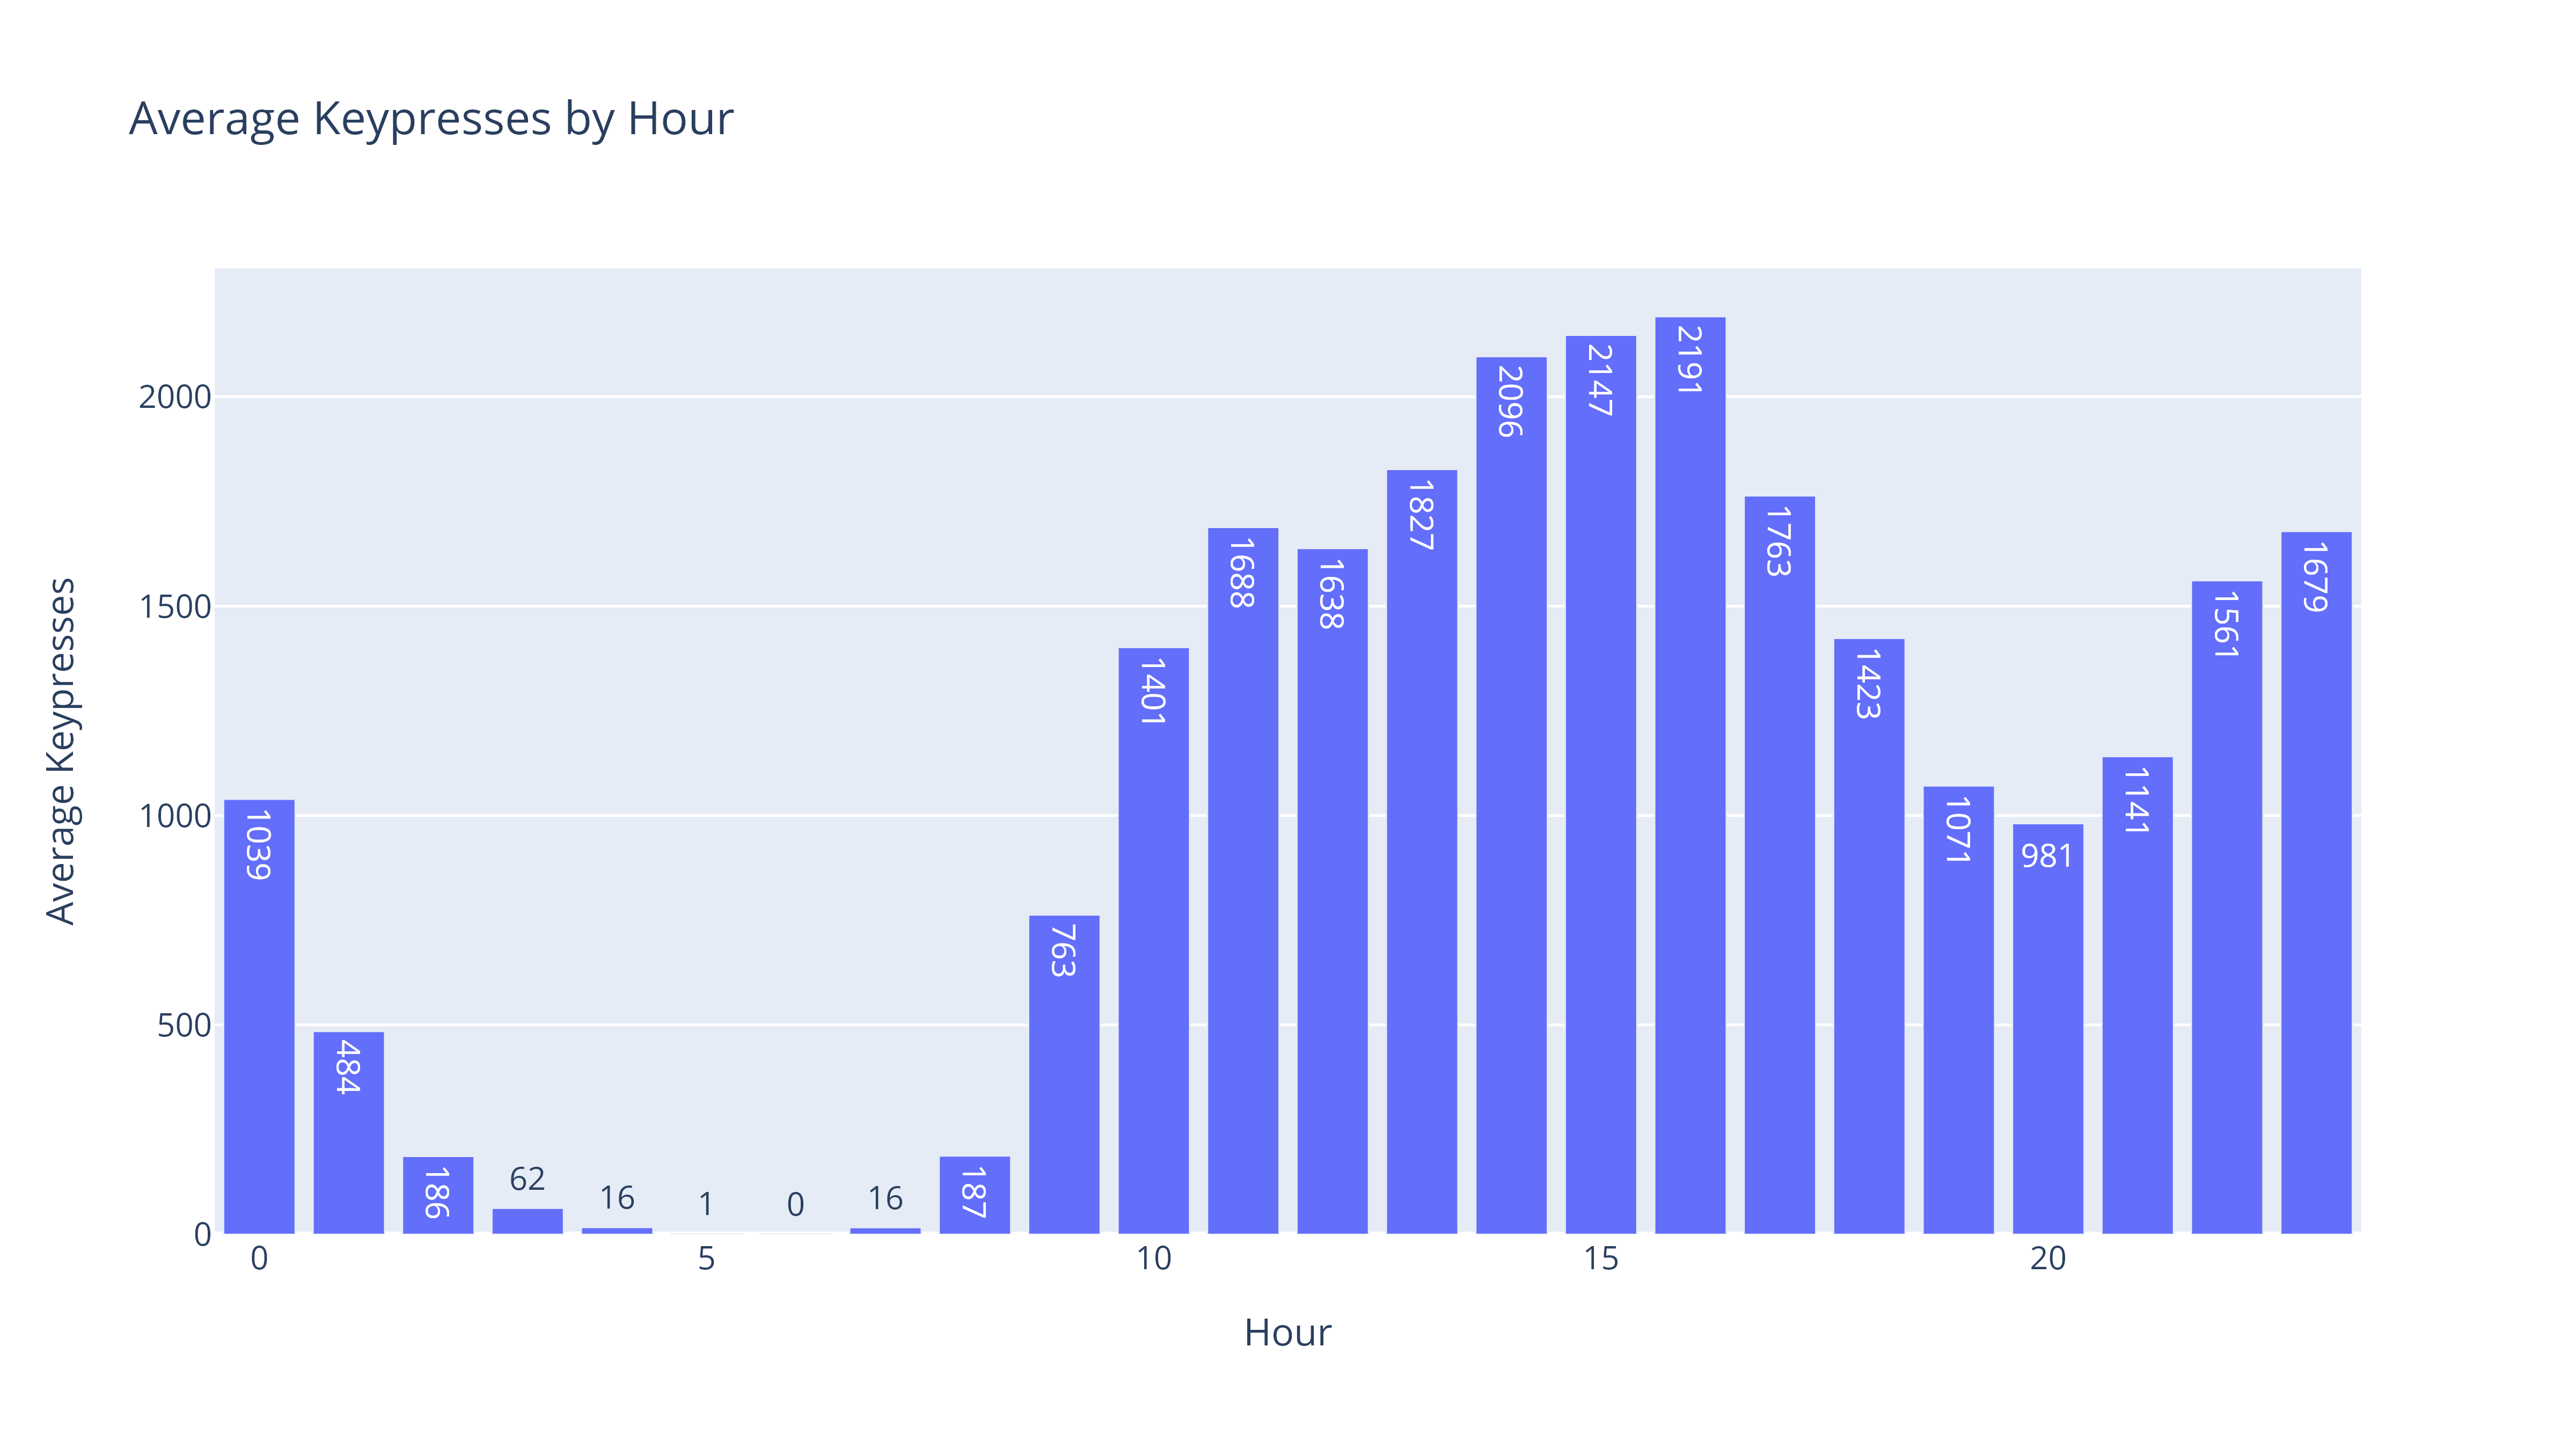

In [58]:
Image(static_graphs_folder+'average_keypresses_by_hour.png')

In [59]:
df_hourly_keypresses['Day'][0]

datetime.date(2020, 9, 21)

Saving the updated version of df_hourly_keypresses to a .csv file:

In [60]:
df_hourly_keypresses.to_csv('data/df_combined_hourly_keypresses_updated.csv')

## Data analysis question: Did marriage change my typing patterns?

I got married in April 2023, and I suspected that my keypress distributions as a married man might skew earlier than they did when I was a bachelor. I decided to investigate this graphically by creating subsets of df_hourly_keypresses that contained pre-marriage and post-marriage datasets, then comparing them via a grouped bar chart.

Setting datetime.date() values that will be used to filter df_hourly_keypresses:

In [61]:
post_mba_work_start_date = datetime.date(2022, 6, 21) # I began my current
# full-time work in June 2022 after finishing my MBA. I chose to limit the
# dataset to this date range so that my results wouldn't be influenced
# by my time as an MBA student (which featured more irregular computer hours).
last_day_before_marriage = datetime.date(2023, 4, 14)
day_after_honeymoon = datetime.date(2023, 4, 29) # I didn't type much at all
# on my honeymoon, so I excluded this period from my analysis in order not
# to skew the average keypress totals downward. 

In [62]:
df_hourly_keypresses_pre_marriage = df_hourly_keypresses.query(
"Day > @post_mba_work_start_date & Day <= @last_day_before_marriage"
).pivot_table(index = 'Hour', values = 'Keypresses', aggfunc = 'mean').reset_index()
df_hourly_keypresses_pre_marriage['Period'] = 'Before Marriage'

df_hourly_keypresses_post_marriage = df_hourly_keypresses.query(
    "Day >= @day_after_honeymoon").pivot_table(
        index = 'Hour', values = 'Keypresses', aggfunc = 'mean').reset_index()
df_hourly_keypresses_post_marriage['Period'] = 'After Marriage'

# Combining these two DataFrames together:
df_hourly_keypresses_by_period = pd.concat([df_hourly_keypresses_pre_marriage,
df_hourly_keypresses_post_marriage])

df_hourly_keypresses_by_period


Hour   Keypresses           Period
0      0   641.848485  Before Marriage
1      1   296.060606  Before Marriage
2      2    58.700337  Before Marriage
3      3    31.047138  Before Marriage
4      4     0.090909  Before Marriage
5      5     0.000000  Before Marriage
6      6     1.138047  Before Marriage
7      7     4.380471  Before Marriage
8      8    62.777778  Before Marriage
9      9   574.838384  Before Marriage
10    10  1439.505051  Before Marriage
11    11  1632.949495  Before Marriage
12    12  1639.750842  Before Marriage
13    13  1856.245791  Before Marriage
14    14  1962.851852  Before Marriage
15    15  2019.952862  Before Marriage
16    16  1950.003367  Before Marriage
17    17  1412.973064  Before Marriage
18    18   941.222222  Before Marriage
19    19   888.138047  Before Marriage
20    20   873.659933  Before Marriage
21    21  1083.676768  Before Marriage
22    22  1323.804714  Before Marriage
23    23  1364.552189  Before Marriage
0      0  1038.467492   After Marriage
1      1   266.263158   After Marriage
2      2   112.269350   After Marriage
3      3    28.882353   After Marriage
4      4    22.250774   After Marriage
5      5     0.000000   After Marriage
6      6     0.000000   After Marriage
7      7    54.566563   After Marriage
8      8   271.743034   After Marriage
9      9  1212.600619   After Marriage
10    10  1878.086687   After Marriage
11    11  2082.340557   After Marriage
12    12  1938.761610   After Marriage
13    13  1939.702786   After Marriage
14    14  2022.464396   After Marriage
15    15  2046.687307   After Marriage
16    16  2070.566563   After Marriage
17    17  1874.136223   After Marriage
18    18  1551.385093   After Marriage
19    19  1125.242236   After Marriage
20    20   786.105590   After Marriage
21    21  1055.357143   After Marriage
22    22  1489.568323   After Marriage
23    23  1749.664596   After Marriage

My daily keypress counts have increased slightly since getting married (at least when the honeymoon isn't taken into account):

In [63]:
df_hourly_keypresses_by_period.pivot_table(
    index = 'Period', values = 'Keypresses', aggfunc = 'sum')

Keypresses
Period                       
After Marriage   26617.112455
Before Marriage  22060.168350

However, as the following chart shows, the hourly distribution of these keypresses has changed significantly. I'm now typing much less late at night and am getting more keypresses in earlier in the day.

In [64]:
fig_keypresses_by_period = px.bar(df_hourly_keypresses_by_period, x = 'Hour', 
y = 'Keypresses', color = 'Period', barmode = 'group', text_auto = '.0f', 
title = 'Average Keypresses by Hour Before and After Getting Married')
save_chart(fig_keypresses_by_period, 'keypresses_before_and_after_marriage')
# See https://plotly.com/python/bar-charts/ 
# for the use of the 'color' and 'barmode' arguments.
fig_keypresses_by_period

c:\Users\kburc\miniforge3\envs\ga15pyd\lib\site-packages\plotly\express\_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



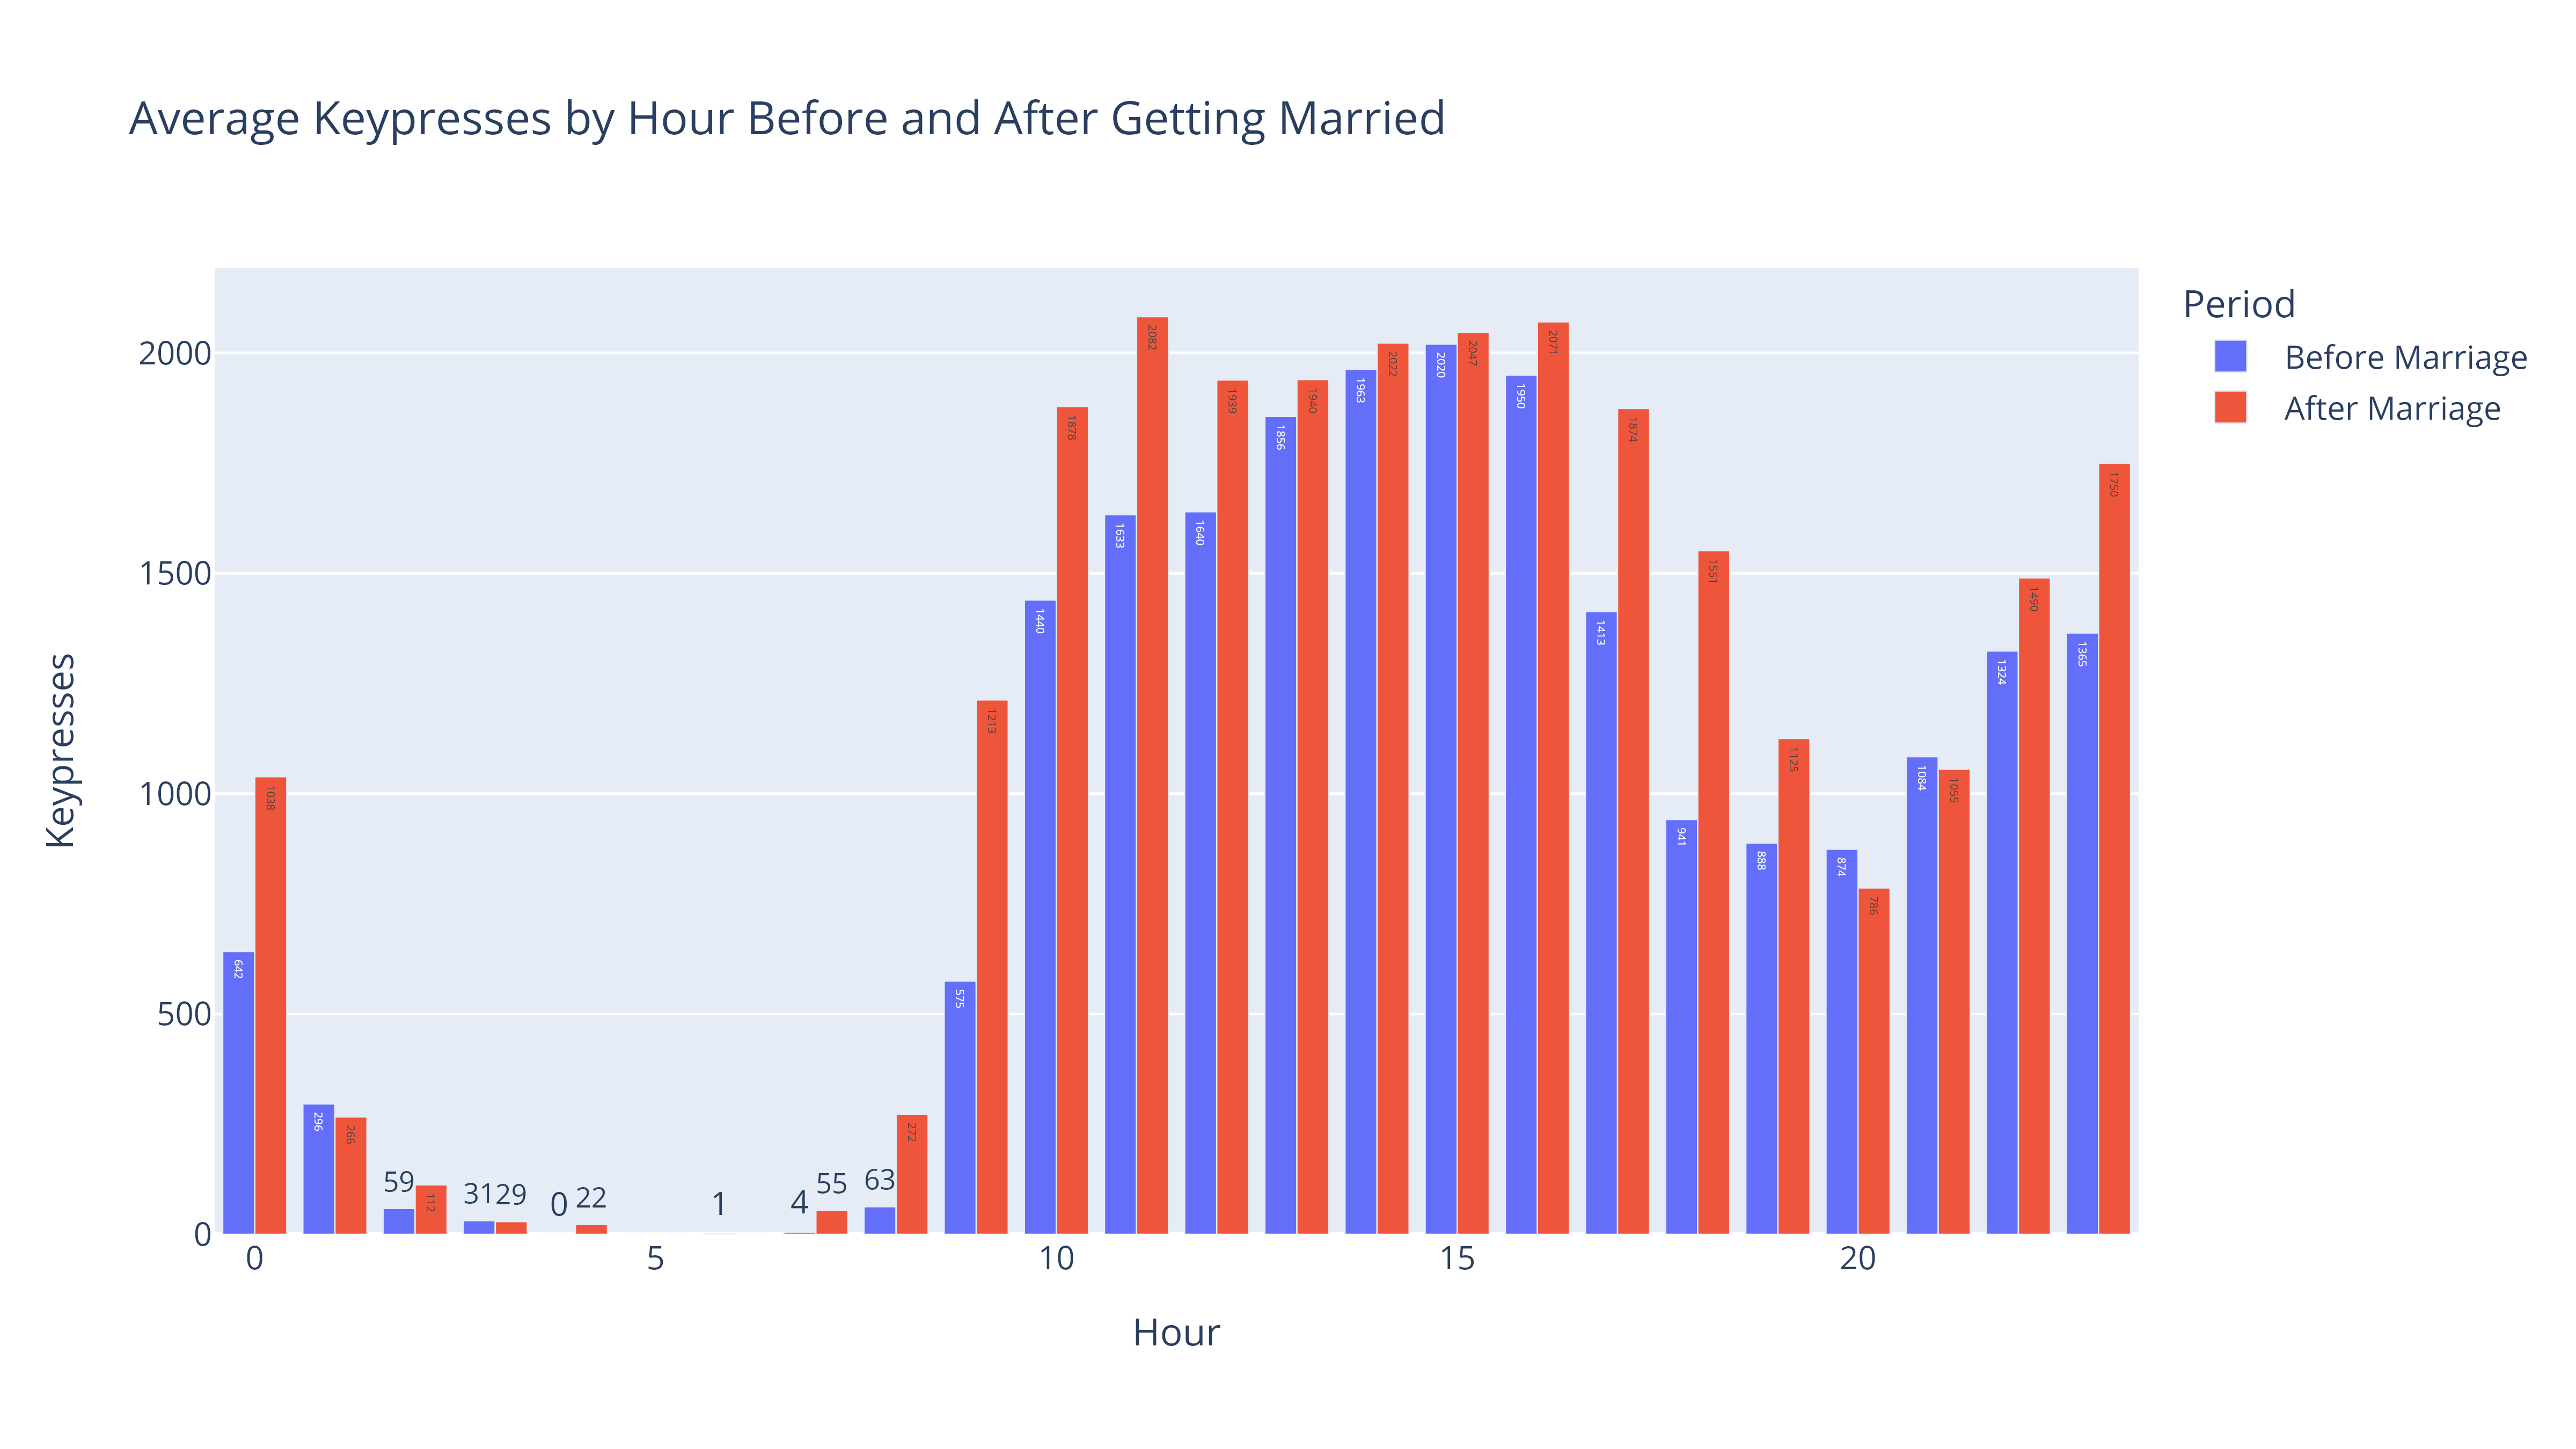

In [65]:
Image(static_graphs_folder+'keypresses_before_and_after_marriage.png')

In [66]:
end_time = time.time()
run_time = end_time - start_time
run_minutes = run_time // 60
run_seconds = run_time % 60

run_minutes, run_seconds


(0.0, 9.556999921798706)

The input() function within the following cell keeps the console window open when running the file in a command prompt. It's not necessary for the Jupyter Notebook, but when I export this notebook as a Python script and then run the script on a scheduled basis, this line gives me time to read the output.
See nosklo's response at: https://stackoverflow.com/a/1000968/13097194

In [67]:
print("The program has finished running. Press Enter to exit.") # Lets me know
# that I can now close the program after it has finished running in a console
# window. (I wouldn't want to close it while the 
# graphs are in the process of being generated.)
input() 


The program has finished running. Press Enter to exit.


''

That's it for this program! I hope you enjoy using it to analyze your own WhatPulse keypress statistics.